CPFV (Combined Probability and Class Feature Vector)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#marge the column
import pandas as pd

# Define the file paths and prefixes
data_paths = {
    "ACC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_AAC.csv",
    "CTDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_CTDC.csv",
    "CTD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_CTD.csv",
    "GDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_GDC.csv",
    "PAAC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_PAAC.csv",
    "PCP": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_PCP.csv",
    "TPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_TPC.csv",
    "CTDT": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_CTDT.csv",
    "DPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_DPC.csv",
    "CTDD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/CPFV_CTDD.csv",
}

processed_dfs = []
final_target_column = None  # To store the unique Target column

# Process each file in the dictionary
for prefix, path in data_paths.items():
    # Load the dataset
    df = pd.read_csv(path)

    # If a 'Target' column exists, store it and ensure only one is retained
    if 'Target' in df.columns:
        if final_target_column is None:
            final_target_column = df['Target']  # Retain the first Target column
        df.drop(columns=['Target'], inplace=True)  # Drop from the current dataset

    # Drop the 'True_Label' column if it exists
    df.drop(columns=['True_Label'], inplace=True, errors='ignore')

    # Rename columns with the prefix
    df = df.rename(columns=lambda col: f"{col}_{prefix}" if 'probabilities' not in col else col)

    # Append the processed DataFrame to the list
    processed_dfs.append(df)

# Concatenate all DataFrames column-wise
combined_df = pd.concat(processed_dfs, axis=1)

# Add the retained 'Target' column to the final dataset
if final_target_column is not None:
    combined_df['Target'] = final_target_column

# Save the combined DataFrame
output_file = "/content/Dataset Marge CPFV.csv"
combined_df.to_csv(output_file, index=False)

print(f"Processed dataset saved to: {output_file}")

Processed dataset saved to: /content/Dataset Marge CPFV.csv


In [ ]:
# Check the shape of the merged dataset
print("Shape of the merged dataset:", combined_df.shape)

Shape of the merged dataset: (300, 240)


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/Optuna_Dataset Marge CPFV.csv")

In [ ]:
df.shape

(300, 241)

In [ ]:

##proposed moded apply for CPFV

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/Optuna_Dataset Marge CPFV.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional: Uncomment if needed to verify column names)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'True_Label' column for binary classification
if 'True_Label' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['True_Label']).values  # Features
y = data['True_Label'].values                 # Labels

# Split data into training and validation sets (70-30 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]

# Model Architecture
model = Sequential()

# Stacked Conv1D layers with BatchNormalization and Dropout
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer for sequential dependencies
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Dense Layers with Dropout
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the validation data
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print evaluation metrics
print("\nValidation Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Cohen's Kappa:", kappa)
print("Area Under Curve (AUC):", auc)
print("\nClassification Report:\n", classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_Class_ACC', 'SVM_Prob_ACC', 'Decision Tree_Class_ACC',
       'Decision Tree_Prob_ACC', 'Random Forest_Class_ACC',
       'Random Forest_Prob_ACC', 'Logistic Regression_Class_ACC',
       'Logistic Regression_Prob_ACC', 'k-NN_Class_ACC', 'k-NN_Prob_ACC',
       ...
       'XGBoost_Prob_CTDD', 'LightGBM_Class_CTDD', 'LightGBM_Prob_CTDD',
       'AdaBoost_Class_CTDD', 'AdaBoost_Prob_CTDD',
       'Neural Network (MLPClassifier)_Class_CTDD',
       'Neural Network (MLPClassifier)_Prob_CTDD',
       'Multilayer Perceptron (Custom MLP)_Class_CTDD',
       'Multilayer Perceptron (Custom MLP)_Prob_CTDD', 'True_Label'],
      dtype='object', length=241)
   SVM_Class_ACC  SVM_Prob_ACC  Decision Tree_Class_ACC  \
0              1      0.899958                        1   
1              1      0.947470                        1   
2              0      0.156467                        0   
3              1      0.623367                        0   
4              1      

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 238, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 238, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 119, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 119, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 117, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 117, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 117, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 115, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 115, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 57, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 57, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,129 (875.50 KB)

 Trainable params: 223,233 (872.00 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.5059 - loss: 12.0306 - val_accuracy: 0.9222 - val_loss: 0.6883
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.6851 - loss: 0.9058 - val_accuracy: 0.5000 - val_loss: 0.6828
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.8136 - loss: 0.3347 - val_accuracy: 0.6111 - val_loss: 0.6772
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - accuracy: 0.8674 - loss: 0.3855 - val_accuracy: 0.8556 - val_loss: 0.6728
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8422 - loss: 0.3918 - val_accuracy: 0.7889 - val_loss: 0.6694
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9111 - loss: 0.3227 - val_accuracy: 0.6444 - val_loss: 0.6669
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9004 - loss: 0.2675 - val_accuracy: 0.6000 - val_loss: 0.6606
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9002 - loss: 0.6790 - val_accuracy: 0.5444 -

In [ ]:
#CROSS VALIDATION FOR cpfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)

# Load dataset
dataset_path = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/Optuna_Dataset Marge CPFV.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track metrics across folds
metrics = {
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "mcc": [],
    "kappa": [],
    "auc": []
}

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Reshape for Conv1D
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Build model
    def build_model():
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(LSTM(64, activation='relu'))

        model.add(Dense(128, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_model()

    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Predict
    val_probs = model.predict(X_val)
    val_preds = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    tn, fp, fn, tp = cm.ravel()

    sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    mcc = matthews_corrcoef(y_val, val_preds)
    kappa = cohen_kappa_score(y_val, val_preds)
    auc = roc_auc_score(y_val, val_probs)

    # Print fold results
    print(f"Accuracy: {acc:.4f} | Sensitivity: {sens:.4f} | Specificity: {spec:.4f} | MCC: {mcc:.4f} | Kappa: {kappa:.4f} | AUC: {auc:.4f}")
    print(classification_report(y_val, val_preds))

    # Store metrics
    metrics["accuracy"].append(acc)
    metrics["sensitivity"].append(sens)
    metrics["specificity"].append(spec)
    metrics["mcc"].append(mcc)
    metrics["kappa"].append(kappa)
    metrics["auc"].append(auc)

    fold += 1

# Average metrics
print("\n========== Average Metrics Across 5 Folds ==========")
for key, values in metrics.items():
    print(f"{key.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")





========== Fold 1 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
Accuracy: 0.9000 | Sensitivity: 0.9000 | Specificity: 0.9000 | MCC: 0.8000 | Kappa: 0.8000 | AUC: 0.9300
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


========== Fold 2 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
Accuracy: 0.9000 | Sensitivity: 1.0000 | Specificity: 0.8000 | MCC: 0.8165 | Kappa: 0.8000 | AUC: 0.9339
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60


========== Fold 3 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
Accuracy: 0.5000 | Sensitivity: 1.0000 | Specificity: 0.0000 | MCC: 0.0000 | Kappa: 0.0000 | AUC: 0.7633
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60


========== Fold 4 ==========


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
Accuracy: 0.5000 | Sensitivity: 0.0000 | Specificity: 1.0000 | MCC: 0.0000 | Kappa: 0.0000 | AUC: 0.5000
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60


========== Fold 5 ==========


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
Accuracy: 0.8667 | Sensitivity: 0.8000 | Specificity: 0.9333 | MCC: 0.7399 | Kappa: 0.7333 | AUC: 0.8600
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        30
           1       0.92      0.80      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


========== Average Metrics Across 5 Folds ==========
Accuracy: 0.7333 ± 0.1909
Sensitivity: 0.7400 ± 0.3774
Specificity: 0.7267 ± 0.3690
Mcc: 0.4713 ± 0.3856
Kappa: 0.4667 ± 0.3818
Auc: 0.7974 ± 0.1611


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from deap import base, creator, tools, algorithms
import random

# Load the dataset
data_path = '/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CPFV (Combined Probability and Class Feature Vector)/Optuna_Dataset Marge CPFV.csv'
data = pd.read_csv(data_path)

# Assuming the last column is the target, split features and labels
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Encode target labels if necessary
if y.dtype == object or np.issubdtype(y.dtype, np.number):  # Handle both string and numeric labels
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))  # Ensure all targets are treated as strings for classification

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the individual and fitness functions
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Classifier to evaluate fitness
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:  # Prevent division by zero
        return 0,

    X_train_selected = X_train.iloc[:, selected_features]
    X_val_selected = X_val.iloc[:, selected_features]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy,

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Parameters for the Genetic Algorithm
population_size = 50
generations = 20
crossover_probability = 0.8
mutation_probability = 0.1

# Initialize population
population = toolbox.population(n=population_size)

# Run the Genetic Algorithm
result_population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=crossover_probability,
    mutpb=mutation_probability,
    ngen=generations,
    verbose=True
)

# Find the best individual
best_individual = tools.selBest(result_population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1 and i < len(X.columns)]  # Bounds check

# Select top 10 features based on their importance
if len(selected_features) > 10:
    feature_importances = pd.Series(best_individual).sort_values(ascending=False)
    selected_features = list(feature_importances.head(10).index)

# Evaluate performance using the top 10 features
X_train_selected = X_train.iloc[:, selected_features]
X_val_selected = X_val.iloc[:, selected_features]

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_val_selected)
final_accuracy = accuracy_score(y_val, final_predictions)

print(f"Top 10 Selected features: {selected_features}")
print(f"Final Accuracy with top 10 selected features: {final_accuracy}")

# Save the top 20 selected features
pd.DataFrame({'Selected Features': selected_features}).to_csv('/content/CPFV_top_10_selected_features.csv', index=False)


gen	nevals
0  	50    
1  	39    
2  	41    
3  	30    
4  	44    
5  	39    
6  	46    
7  	41    
8  	35    
9  	45    
10 	38    
11 	42    
12 	35    
13 	37    
14 	35    
15 	47    
16 	45    
17 	43    
18 	36    
19 	44    
20 	37    
Top 10 Selected features: [0, 2, 3, 7, 6, 10, 9, 8, 15, 14]
Final Accuracy with top 10 selected features: 0.9


In [ ]:
selected_feature_columns = data.columns[selected_features]
# Create a filtered dataset with only the selected top 20 features
filtered_data = data[selected_feature_columns.tolist() + [data.columns[-1]]]
filtered_data_path = '/content/CPFV_Top_10_Features.csv'
filtered_data.to_csv(filtered_data_path, index=False)

print(f"Filtered dataset with top 10 features saved to: {filtered_data_path}")

Filtered dataset with top 10 features saved to: /content/CPFV_Top_10_Features.csv


In [ ]:
data=pd.read_csv("/content/CPFV_Top_10_Features.csv")


In [ ]:
data.shape

(300, 11)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/CPFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset
print("Dataset Columns:", data.columns)
print("Shape before processing:", data.shape)
print(data.head())

# Check for target column
if 'True_Label' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print("\nShapes after reshaping:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Model Architecture
model = Sequential()

# First Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D layer
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Global pooling
model.add(GlobalMaxPooling1D())

# Dense Layers
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model Summary
model.summary()

# Train the model
print("\nTraining model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

# Evaluate the model
print("\nEvaluating model...")
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Metrics Calculation
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print Metrics
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Area Under Curve (AUC): {auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_Class_ACC', 'Decision Tree_Class_ACC', 'Decision Tree_Prob_ACC',
       'Logistic Regression_Prob_ACC', 'Logistic Regression_Class_ACC',
       'Naive Bayes_Class_ACC', 'k-NN_Prob_ACC', 'k-NN_Class_ACC',
       'XGBoost_Prob_ACC', 'XGBoost_Class_ACC', 'True_Label'],
      dtype='object')
Shape before processing: (300, 11)
   SVM_Class_ACC  Decision Tree_Class_ACC  Decision Tree_Prob_ACC  \
0              1                        1                 0.91200   
1              1                        1                 0.99537   
2              0                        0                 0.00000   
3              1                        0                 0.00000   
4              1                        0                 0.00000   

   Logistic Regression_Prob_ACC  Logistic Regression_Class_ACC  \
0                      0.756727                              1   
1                      0.990390                              1   
2                      0.337374   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,529 (650.50 KB)

 Trainable params: 165,633 (647.00 KB)

 Non-trainable params: 896 (3.50 KB)


Training model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6734 - loss: 0.9226 - precision: 0.6605 - recall: 0.6369 - val_accuracy: 0.8667 - val_loss: 0.6623 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8681 - loss: 0.4728 - precision: 0.8647 - recall: 0.8754 - val_accuracy: 0.8667 - val_loss: 0.6576 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8712 - loss: 0.3703 - precision: 0.8507 - recall: 0.9033 - val_accuracy: 0.8667 - val_loss: 0.6573 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8380 - loss: 0.5190 - precision: 0.8527 - recall: 0.8456 - val_accuracy: 0.8778 - val_loss: 0.6507 - val_precision: 0.8864 - val_recall: 0.8667
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8611 - loss: 0.3812 - precision: 0.8413 - recall: 0.9002 - val_accuracy: 0.8889 - v

In [ ]:
#cross validation for cpfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold

# Load the dataset
dataset_path = "/content/CPFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for Conv1D
X = X.reshape(X.shape[0], X.shape[1], 1)

# Set up Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For storing metrics
accs, sens_list, specs, mccs, kappas, aucs = [], [], [], [], [], []

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n----- Fold {fold} -----")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    val_probs = model.predict(X_val)
    val_pred = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_pred)
    conf = confusion_matrix(y_val, val_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    mcc = matthews_corrcoef(y_val, val_pred)
    kappa = cohen_kappa_score(y_val, val_pred)
    auc = roc_auc_score(y_val, val_probs)

    # Append to lists
    accs.append(acc)
    sens_list.append(sens)
    specs.append(spec)
    mccs.append(mcc)
    kappas.append(kappa)
    aucs.append(auc)

    print(f"Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, MCC: {mcc:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}")
    fold += 1

# Print average performance
print("\n===== Cross-Validation Results =====")
print(f"Average Accuracy: {np.mean(accs):.4f}")
print(f"Average Sensitivity: {np.mean(sens_list):.4f}")
print(f"Average Specificity: {np.mean(specs):.4f}")
print(f"Average MCC: {np.mean(mccs):.4f}")
print(f"Average Kappa: {np.mean(kappas):.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")



----- Fold 1 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Accuracy: 0.8667, Sensitivity: 0.9333, Specificity: 0.8000, MCC: 0.7399, Kappa: 0.7333, AUC: 0.9500

----- Fold 2 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Accuracy: 0.9167, Sensitivity: 0.9667, Specificity: 0.8667, MCC: 0.8375, Kappa: 0.8333, AUC: 0.9800

----- Fold 3 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
Accuracy: 0.9500, Sensitivity: 0.9000, Specificity: 1.0000, MCC: 0.9045, Kappa: 0.9000, AUC: 0.9711

----- Fold 4 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Accuracy: 0.7833, Sensitivity: 0.7000, Specificity: 0.8667, MCC: 0.5747, Kappa: 0.5667, AUC: 0.9133

----- Fold 5 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Accuracy: 0.8667, Sensitivity: 0.8667, Specificity: 0.8667, MCC: 0.7333, Kappa: 0.7333, AUC: 0.9489

===== Cross-Validation Results =====
Average Accuracy: 0.8767
Average Sensitivity: 0.8733
Average Specificity: 0.8800
Average MCC: 0.7580
Average Kappa: 0.7533
Average AUC: 0.9527


Class Feature Vector (CFV)

In [ ]:
#marge the column
import pandas as pd

# Define the file paths and prefixes
data_paths = {
    "ACC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_AAC.csv",
    "CTDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_CTDC (1).csv",
    "CTD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_CTD (3).csv",
    "GDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_GDC.csv",
    "PAAC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_PAAC.csv",
    "PCP": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_PCP.csv",
    "TPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_TPC.csv",
    "CTDT": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_CTDT.csv",
    "DPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_DPC (1).csv",
    "CTDD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/CFV_CTDD.csv",
}

processed_dfs = []
final_target_column = None  # To store the unique Target column

# Process each file in the dictionary
for prefix, path in data_paths.items():
    # Load the dataset
    df = pd.read_csv(path)

    # If a 'Target' column exists, store it and ensure only one is retained
    if 'Target' in df.columns:
        if final_target_column is None:
            final_target_column = df['Target']  # Retain the first Target column
        df.drop(columns=['Target'], inplace=True)  # Drop from the current dataset

    # Drop the 'True_Label' column if it exists
    df.drop(columns=['True_Label'], inplace=True, errors='ignore')

    # Rename columns with the prefix
    df = df.rename(columns=lambda col: f"{col}_{prefix}" if 'probabilities' not in col else col)

    # Append the processed DataFrame to the list
    processed_dfs.append(df)

# Concatenate all DataFrames column-wise
combined_df = pd.concat(processed_dfs, axis=1)

# Add the retained 'Target' column to the final dataset
if final_target_column is not None:
    combined_df['Target'] = final_target_column

# Save the combined DataFrame
output_file = "/content/Optuna_Dataset Marge CFV.csv"
combined_df.to_csv(output_file, index=False)

print(f"Processed dataset saved to: {output_file}")

Processed dataset saved to: /content/Optuna_Dataset Marge CFV.csv


In [ ]:
# Check the shape of the merged dataset
print("Shape of the merged dataset:", combined_df.shape)

Shape of the merged dataset: (300, 120)


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/Optuna_Dataset Marge CFV.csv")

In [ ]:
df.shape

(300, 121)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/Optuna_Dataset Marge CFV.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional: Uncomment if needed to verify column names)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'True_Label' column for binary classification
if 'True_Label' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['True_Label']).values  # Features
y = data['True_Label'].values                 # Labels

# Split data into training and validation sets (70-30 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]

# Model Architecture
model = Sequential()

# Stacked Conv1D layers with BatchNormalization and Dropout
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer for sequential dependencies
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Dense Layers with Dropout
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the validation data
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print evaluation metrics
print("\nValidation Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Cohen's Kappa:", kappa)
print("Area Under Curve (AUC):", auc)
print("\nClassification Report:\n", classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_ACC', 'Decision Tree_ACC', 'Random Forest_ACC',
       'Logistic Regression_ACC', 'k-NN_ACC', 'Naive Bayes_ACC',
       'Gradient Boosting_ACC', 'XGBoost_ACC', 'LightGBM_ACC', 'AdaBoost_ACC',
       ...
       'Logistic Regression_CTDD', 'k-NN_CTDD', 'Naive Bayes_CTDD',
       'Gradient Boosting_CTDD', 'XGBoost_CTDD', 'LightGBM_CTDD',
       'AdaBoost_CTDD', 'Neural Network_CTDD', 'MLP_CTDD', 'True_Label'],
      dtype='object', length=121)
    SVM_ACC  Decision Tree_ACC  Random Forest_ACC  Logistic Regression_ACC  \
0  0.830810           0.919355           0.777252                 0.824422   
1  0.987548           1.000000           0.993010                 0.997619   
2  0.211028           0.000000           0.212838                 0.313903   
3  0.552428           0.000000           0.561655                 0.560973   
4  0.607083           0.500000           0.403041                 0.389037   

   k-NN_ACC  Naive Bayes_ACC  Gradient Boosting_ACC  XGBo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 118, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 118, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 57, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 57, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 57, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 55, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 55, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,129 (875.50 KB)

 Trainable params: 223,233 (872.00 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.6185 - loss: 0.7120 - val_accuracy: 0.8889 - val_loss: 0.6803
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8982 - loss: 0.5215 - val_accuracy: 0.9000 - val_loss: 0.6706
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9077 - loss: 0.2572 - val_accuracy: 0.9000 - val_loss: 0.6696
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9235 - loss: 0.2122 - val_accuracy: 0.9333 - val_loss: 0.6697
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9199 - loss: 0.1889 - val_accuracy: 0.9333 - val_loss: 0.6709
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8988 - loss: 0.3256 - val_accuracy: 0.7556 - val_loss: 0.6633
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.9110 - loss: 0.2738 - val_accuracy: 0.6222 - val_loss: 0.6467
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9213 - loss: 0.1686 - val_accuracy: 0.6444 - 

In [ ]:
#CROSS VALIDATION FOR cfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)

# Load dataset
dataset_path = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/Optuna_Dataset Marge CFV.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track metrics across folds
metrics = {
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "mcc": [],
    "kappa": [],
    "auc": []
}

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Reshape for Conv1D
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Build model
    def build_model():
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(LSTM(64, activation='relu'))

        model.add(Dense(128, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_model()

    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Predict
    val_probs = model.predict(X_val)
    val_preds = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    tn, fp, fn, tp = cm.ravel()

    sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    mcc = matthews_corrcoef(y_val, val_preds)
    kappa = cohen_kappa_score(y_val, val_preds)
    auc = roc_auc_score(y_val, val_probs)

    # Print fold results
    print(f"Accuracy: {acc:.4f} | Sensitivity: {sens:.4f} | Specificity: {spec:.4f} | MCC: {mcc:.4f} | Kappa: {kappa:.4f} | AUC: {auc:.4f}")
    print(classification_report(y_val, val_preds))

    # Store metrics
    metrics["accuracy"].append(acc)
    metrics["sensitivity"].append(sens)
    metrics["specificity"].append(spec)
    metrics["mcc"].append(mcc)
    metrics["kappa"].append(kappa)
    metrics["auc"].append(auc)

    fold += 1

# Average metrics
print("\n========== Average Metrics Across 5 Folds ==========")
for key, values in metrics.items():
    print(f"{key.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")





========== Fold 1 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
Accuracy: 0.9000 | Sensitivity: 0.9333 | Specificity: 0.8667 | MCC: 0.8018 | Kappa: 0.8000 | AUC: 0.9589
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.93      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


========== Fold 2 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
Accuracy: 0.9500 | Sensitivity: 0.9667 | Specificity: 0.9333 | MCC: 0.9005 | Kappa: 0.9000 | AUC: 0.9889
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.94      0.97      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


========== Fold 3 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
Accuracy: 0.9000 | Sensitivity: 0.8667 | Specificity: 0.9333 | MCC: 0.8018 | Kappa: 0.8000 | AUC: 0.9667
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.93      0.87      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


========== Fold 4 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
Accuracy: 0.9000 | Sensitivity: 0.9000 | Specificity: 0.9000 | MCC: 0.8000 | Kappa: 0.8000 | AUC: 0.9606
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


========== Fold 5 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
Accuracy: 0.8833 | Sensitivity: 0.8667 | Specificity: 0.9000 | MCC: 0.7671 | Kappa: 0.7667 | AUC: 0.9167
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60


========== Average Metrics Across 5 Folds ==========
Accuracy: 0.9067 ± 0.0226
Sensitivity: 0.9067 ± 0.0389
Specificity: 0.9067 ± 0.0249
Mcc: 0.8142 ± 0.0451
Kappa: 0.8133 ± 0.0452
Auc: 0.9583 ± 0.0234


In [ ]:
!pip install deap

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from deap import base, creator, tools, algorithms
import random

# Load the dataset
data_path = '/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Class Feature Vector (CFV)/Optuna_Dataset Marge CFV.csv'
data = pd.read_csv(data_path)

# Assuming the last column is the target, split features and labels
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Encode target labels if necessary
if y.dtype == object or np.issubdtype(y.dtype, np.number):  # Handle both string and numeric labels
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))  # Ensure all targets are treated as strings for classification

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the individual and fitness functions
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Classifier to evaluate fitness
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:  # Prevent division by zero
        return 0,

    X_train_selected = X_train.iloc[:, selected_features]
    X_val_selected = X_val.iloc[:, selected_features]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy,

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Parameters for the Genetic Algorithm
population_size = 50
generations = 20
crossover_probability = 0.8
mutation_probability = 0.1

# Initialize population
population = toolbox.population(n=population_size)

# Run the Genetic Algorithm
result_population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=crossover_probability,
    mutpb=mutation_probability,
    ngen=generations,
    verbose=True
)

# Find the best individual
best_individual = tools.selBest(result_population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1 and i < len(X.columns)]  # Bounds check

# Select top 20 features based on their importance
if len(selected_features) > 10:
    feature_importances = pd.Series(best_individual).sort_values(ascending=False)
    selected_features = list(feature_importances.head(10).index)

# Evaluate performance using the top 10 features
X_train_selected = X_train.iloc[:, selected_features]
X_val_selected = X_val.iloc[:, selected_features]

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_val_selected)
final_accuracy = accuracy_score(y_val, final_predictions)

print(f"Top 10 Selected features: {selected_features}")
print(f"Final Accuracy with top 10 selected features: {final_accuracy}")

# Save the top 20 selected features
pd.DataFrame({'Selected Features': selected_features}).to_csv('/content/CFV_top_10_selected_features.csv', index=False)


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	41    
2  	36    
3  	44    
4  	40    
5  	40    
6  	39    
7  	39    
8  	48    
9  	39    
10 	42    
11 	44    
12 	38    
13 	43    
14 	37    
15 	45    
16 	34    
17 	38    
18 	36    
19 	37    
20 	40    
Top 10 Selected features: [0, 1, 2, 3, 4, 5, 10, 8, 20, 21]
Final Accuracy with top 10 selected features: 0.9166666666666666


In [ ]:
selected_feature_columns = data.columns[selected_features]
# Create a filtered dataset with only the selected top 10 features
filtered_data = data[selected_feature_columns.tolist() + [data.columns[-1]]]
filtered_data_path = '/content/CFV_Top_10_Features.csv'
filtered_data.to_csv(filtered_data_path, index=False)

print(f"Filtered dataset with top 10 features saved to: {filtered_data_path}")

Filtered dataset with top 10 features saved to: /content/CFV_Top_10_Features.csv


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/CFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset
print("Dataset Columns:", data.columns)
print("Shape before processing:", data.shape)
print(data.head())

# Check for target column
if 'True_Label' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print("\nShapes after reshaping:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Model Architecture
model = Sequential()

# First Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D layer
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Global pooling
model.add(GlobalMaxPooling1D())

# Dense Layers
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model Summary
model.summary()

# Train the model
print("\nTraining model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

# Evaluate the model
print("\nEvaluating model...")
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Metrics Calculation
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print Metrics
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Area Under Curve (AUC): {auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_ACC', 'Decision Tree_ACC', 'Random Forest_ACC',
       'Logistic Regression_ACC', 'k-NN_ACC', 'Naive Bayes_ACC',
       'Neural Network_ACC', 'LightGBM_ACC', 'LightGBM_CTDC', 'AdaBoost_CTDC',
       'True_Label'],
      dtype='object')
Shape before processing: (300, 11)
    SVM_ACC  Decision Tree_ACC  Random Forest_ACC  Logistic Regression_ACC  \
0  0.830810           0.919355           0.777252                 0.824422   
1  0.987548           1.000000           0.993010                 0.997619   
2  0.211028           0.000000           0.212838                 0.313903   
3  0.552428           0.000000           0.561655                 0.560973   
4  0.607083           0.500000           0.403041                 0.389037   

   k-NN_ACC  Naive Bayes_ACC  Neural Network_ACC  LightGBM_ACC  LightGBM_CTDC  \
0  1.000000         0.892723            0.994922      0.974355       0.999731   
1  1.000000         1.000000            1.000000      0.999663       

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,529 (650.50 KB)

 Trainable params: 165,633 (647.00 KB)

 Non-trainable params: 896 (3.50 KB)


Training model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.7387 - loss: 0.7710 - precision: 0.7299 - recall: 0.7668 - val_accuracy: 0.8667 - val_loss: 0.6318 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8855 - loss: 0.3660 - precision: 0.8550 - recall: 0.9384 - val_accuracy: 0.8667 - val_loss: 0.6074 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9058 - loss: 0.3939 - precision: 0.9259 - recall: 0.8908 - val_accuracy: 0.8667 - val_loss: 0.6005 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9018 - loss: 0.3218 - precision: 0.8926 - recall: 0.8900 - val_accuracy: 0.8667 - val_loss: 0.5950 - val_precision: 0.8667 - val_recall: 0.8667
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8849 - loss: 0.3372 - precision: 0.8683 - recall: 0.9207 - val_accuracy: 0.8667 - v

In [ ]:
#cross validation for cfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold

# Load the dataset
dataset_path = "/content/CFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['True_Label']).values
y = data['True_Label'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for Conv1D
X = X.reshape(X.shape[0], X.shape[1], 1)

# Set up Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For storing metrics
accs, sens_list, specs, mccs, kappas, aucs = [], [], [], [], [], []

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n----- Fold {fold} -----")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    val_probs = model.predict(X_val)
    val_pred = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_pred)
    conf = confusion_matrix(y_val, val_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    mcc = matthews_corrcoef(y_val, val_pred)
    kappa = cohen_kappa_score(y_val, val_pred)
    auc = roc_auc_score(y_val, val_probs)

    # Append to lists
    accs.append(acc)
    sens_list.append(sens)
    specs.append(spec)
    mccs.append(mcc)
    kappas.append(kappa)
    aucs.append(auc)

    print(f"Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, MCC: {mcc:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}")
    fold += 1

# Print average performance
print("\n===== Cross-Validation Results =====")
print(f"Average Accuracy: {np.mean(accs):.4f}")
print(f"Average Sensitivity: {np.mean(sens_list):.4f}")
print(f"Average Specificity: {np.mean(specs):.4f}")
print(f"Average MCC: {np.mean(mccs):.4f}")
print(f"Average Kappa: {np.mean(kappas):.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")



----- Fold 1 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Accuracy: 0.9167, Sensitivity: 0.9667, Specificity: 0.8667, MCC: 0.8375, Kappa: 0.8333, AUC: 0.9667

----- Fold 2 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Accuracy: 0.9167, Sensitivity: 0.9667, Specificity: 0.8667, MCC: 0.8375, Kappa: 0.8333, AUC: 0.9933

----- Fold 3 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Accuracy: 0.9333, Sensitivity: 0.9000, Specificity: 0.9667, MCC: 0.8686, Kappa: 0.8667, AUC: 0.9578

----- Fold 4 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Accuracy: 0.8833, Sensitivity: 0.8667, Specificity: 0.9000, MCC: 0.7671, Kappa: 0.7667, AUC: 0.9500

----- Fold 5 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Accuracy: 0.9000, Sensitivity: 0.9000, Specificity: 0.9000, MCC: 0.8000, Kappa: 0.8000, AUC: 0.9433

===== Cross-Validation Results =====
Average Accuracy: 0.9100
Average Sensitivity: 0.9200
Average Specificity: 0.9000
Average MCC: 0.8222
Average Kappa: 0.8200
Average AUC: 0.9622


PFV (Probability Feature Vector)

In [ ]:
#marge the column
import pandas as pd

# Define the file paths and prefixes
data_paths = {
    "ACC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_AAC_OPTUNA_probability_predictions.csv",
    "CTDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_CTDC_OPTUNA_probability_predictions.csv",
    "CTD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_CTD_OPTUNA_probability_predictions.csv",
    "GDC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_GDC_OPTUNA_probability_predictions.csv",
    "PAAC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_PAAC_OPTUNA_probability_predictions.csv",
    "PCP": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_PCP_OPTUNA_probability_predictions.csv",
    "TPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_TPC_OPTUNA_probability_predictions.csv",
    "CTDT": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_CTDT_OPTUNA_probability_predictions.csv",
    "DPC": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_DPC_OPTUNA_probability_predictions.csv",
    "CTDD": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/N_CTDD_OPTUNA_probability_predictions.csv",
}

processed_dfs = []
final_target_column = None  # To store the unique Target column

# Process each file in the dictionary
for prefix, path in data_paths.items():
    # Load the dataset
    df = pd.read_csv(path)

    # If a 'Target' column exists, store it and ensure only one is retained
    if 'Target' in df.columns:
        if final_target_column is None:
            final_target_column = df['Target']  # Retain the first Target column
        df.drop(columns=['Target'], inplace=True)  # Drop from the current dataset

    # Drop the 'True_Label' column if it exists
    df.drop(columns=['True_Label'], inplace=True, errors='ignore')

    # Rename columns with the prefix
    df = df.rename(columns=lambda col: f"{col}_{prefix}" if 'probabilities' not in col else col)

    # Append the processed DataFrame to the list
    processed_dfs.append(df)

# Concatenate all DataFrames column-wise
combined_df = pd.concat(processed_dfs, axis=1)

# Add the retained 'Target' column to the final dataset
if final_target_column is not None:
    combined_df['Target'] = final_target_column

# Save the combined DataFrame
output_file = "/content/Optuna_Dataset Marge PFV.csv"
combined_df.to_csv(output_file, index=False)

print(f"Processed dataset saved to: {output_file}")

Processed dataset saved to: /content/Optuna_Dataset Marge PFV.csv


In [ ]:
# Check the shape of the merged dataset
print("Shape of the merged dataset:", combined_df.shape)

Shape of the merged dataset: (300, 121)


In [ ]:
df=pd.read_csv("/content/Optuna_Dataset Marge PFV.csv")

In [ ]:
df.shape

(300, 121)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/Optuna_Dataset Marge PFV.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional: Uncomment if needed to verify column names)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'True_Label' column for binary classification
if 'Target' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['Target']).values  # Features
y = data['Target'].values                 # Labels

# Split data into training and validation sets (70-30 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]

# Model Architecture
model = Sequential()

# Stacked Conv1D layers with BatchNormalization and Dropout
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer for sequential dependencies
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Dense Layers with Dropout
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the validation data
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print evaluation metrics
print("\nValidation Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Cohen's Kappa:", kappa)
print("Area Under Curve (AUC):", auc)
print("\nClassification Report:\n", classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_ACC', 'Decision Tree_ACC', 'Random Forest_ACC',
       'Logistic Regression_ACC', 'k-NN_ACC', 'Naive Bayes_ACC',
       'Gradient Boosting_ACC', 'XGBoost_ACC', 'LightGBM_ACC', 'AdaBoost_ACC',
       ...
       'Logistic Regression_CTDD', 'k-NN_CTDD', 'Naive Bayes_CTDD',
       'Gradient Boosting_CTDD', 'XGBoost_CTDD', 'LightGBM_CTDD',
       'AdaBoost_CTDD', 'Neural Network_CTDD', 'MLP_CTDD', 'Target'],
      dtype='object', length=121)
    SVM_ACC  Decision Tree_ACC  Random Forest_ACC  Logistic Regression_ACC  \
0  0.823857           0.977778           0.719734                 0.828746   
1  0.985450           1.000000           1.000000                 0.997871   
2  0.223416           0.000000           0.200000                 0.312154   
3  0.555763           0.000000           0.643902                 0.561625   
4  0.605909           0.000000           0.342683                 0.384698   

   k-NN_ACC  Naive Bayes_ACC  Gradient Boosting_ACC  XGBoost_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 118, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 118, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 57, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 57, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 57, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 55, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 55, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,129 (875.50 KB)

 Trainable params: 223,233 (872.00 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.7369 - loss: 0.5206 - val_accuracy: 0.8889 - val_loss: 0.6706
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9114 - loss: 0.3283 - val_accuracy: 0.5000 - val_loss: 0.6649
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.8991 - loss: 0.2953 - val_accuracy: 0.5000 - val_loss: 0.6572
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.8891 - loss: 0.2924 - val_accuracy: 0.5000 - val_loss: 0.6503
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.9217 - loss: 0.1996 - val_accuracy: 0.5556 - val_loss: 0.6319
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9059 - loss: 0.1681 - val_accuracy: 0.7667 - val_loss: 0.6126
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9223 - loss: 0.2113 - val_accuracy: 0.8444 - val_loss: 0.6055
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9286 - loss: 0.2058 - val_accuracy: 0.8556 - 

In [ ]:
#CROSS VALIDATION FOR pfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)

# Load dataset
dataset_path = "/content/Optuna_Dataset Marge PFV.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['Target']).values
y = data['Target'].values

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track metrics across folds
metrics = {
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "mcc": [],
    "kappa": [],
    "auc": []
}

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Reshape for Conv1D
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Build model
    def build_model():
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(LSTM(64, activation='relu'))

        model.add(Dense(128, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='swish'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_model()

    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Predict
    val_probs = model.predict(X_val)
    val_preds = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    tn, fp, fn, tp = cm.ravel()

    sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    mcc = matthews_corrcoef(y_val, val_preds)
    kappa = cohen_kappa_score(y_val, val_preds)
    auc = roc_auc_score(y_val, val_probs)

    # Print fold results
    print(f"Accuracy: {acc:.4f} | Sensitivity: {sens:.4f} | Specificity: {spec:.4f} | MCC: {mcc:.4f} | Kappa: {kappa:.4f} | AUC: {auc:.4f}")
    print(classification_report(y_val, val_preds))

    # Store metrics
    metrics["accuracy"].append(acc)
    metrics["sensitivity"].append(sens)
    metrics["specificity"].append(spec)
    metrics["mcc"].append(mcc)
    metrics["kappa"].append(kappa)
    metrics["auc"].append(auc)

    fold += 1

# Average metrics
print("\n========== Average Metrics Across 5 Folds ==========")
for key, values in metrics.items():
    print(f"{key.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")





========== Fold 1 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
Accuracy: 0.8833 | Sensitivity: 0.9000 | Specificity: 0.8667 | MCC: 0.7671 | Kappa: 0.7667 | AUC: 0.9556
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60


========== Fold 2 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
Accuracy: 0.8833 | Sensitivity: 0.9000 | Specificity: 0.8667 | MCC: 0.7671 | Kappa: 0.7667 | AUC: 0.9667
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60


========== Fold 3 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Accuracy: 0.9167 | Sensitivity: 0.8667 | Specificity: 0.9667 | MCC: 0.8375 | Kappa: 0.8333 | AUC: 0.9678
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        30
           1       0.96      0.87      0.91        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60


========== Fold 4 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
Accuracy: 0.9000 | Sensitivity: 0.9000 | Specificity: 0.9000 | MCC: 0.8000 | Kappa: 0.8000 | AUC: 0.9667
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


========== Fold 5 ==========


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
Accuracy: 0.8833 | Sensitivity: 0.8667 | Specificity: 0.9000 | MCC: 0.7671 | Kappa: 0.7667 | AUC: 0.9511
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60


========== Average Metrics Across 5 Folds ==========
Accuracy: 0.8933 ± 0.0133
Sensitivity: 0.8867 ± 0.0163
Specificity: 0.9000 ± 0.0365
Mcc: 0.7878 ± 0.0280
Kappa: 0.7867 ± 0.0267
Auc: 0.9616 ± 0.0069


In [ ]:
df.columns

Index(['SVM_ACC', 'Decision Tree_ACC', 'Random Forest_ACC',
       'Logistic Regression_ACC', 'k-NN_ACC', 'Naive Bayes_ACC',
       'Gradient Boosting_ACC', 'XGBoost_ACC', 'LightGBM_ACC', 'AdaBoost_ACC',
       ...
       'Logistic Regression_CTDD', 'k-NN_CTDD', 'Naive Bayes_CTDD',
       'Gradient Boosting_CTDD', 'XGBoost_CTDD', 'LightGBM_CTDD',
       'AdaBoost_CTDD', 'Neural Network_CTDD', 'MLP_CTDD', 'Target'],
      dtype='object', length=121)

In [ ]:
!pip install deap

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from deap import base, creator, tools, algorithms
import random

# Load the dataset
data_path = '/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/Probabilites Dataset Marge/Optuna_Dataset Marge PFV (1).csv'
data = pd.read_csv(data_path)

# Assuming the last column is the target, split features and labels
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Encode target labels if necessary
if y.dtype == object or np.issubdtype(y.dtype, np.number):  # Handle both string and numeric labels
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))  # Ensure all targets are treated as strings for classification

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the individual and fitness functions
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Classifier to evaluate fitness
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:  # Prevent division by zero
        return 0,

    X_train_selected = X_train.iloc[:, selected_features]
    X_val_selected = X_val.iloc[:, selected_features]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy,

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Parameters for the Genetic Algorithm
population_size = 50
generations = 20
crossover_probability = 0.8
mutation_probability = 0.1

# Initialize population
population = toolbox.population(n=population_size)

# Run the Genetic Algorithm
result_population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=crossover_probability,
    mutpb=mutation_probability,
    ngen=generations,
    verbose=True
)

# Find the best individual
best_individual = tools.selBest(result_population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1 and i < len(X.columns)]  # Bounds check

# Select top 20 features based on their importance
if len(selected_features) > 10:
    feature_importances = pd.Series(best_individual).sort_values(ascending=False)
    selected_features = list(feature_importances.head(10).index)

# Evaluate performance using the top 10 features
X_train_selected = X_train.iloc[:, selected_features]
X_val_selected = X_val.iloc[:, selected_features]

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_val_selected)
final_accuracy = accuracy_score(y_val, final_predictions)

print(f"Top 10 Selected features: {selected_features}")
print(f"Final Accuracy with top 10 selected features: {final_accuracy}")

# Save the top 20 selected features
pd.DataFrame({'Selected Features': selected_features}).to_csv('/content/PFV_top_10_selected_features.csv', index=False)


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	40    
2  	45    
3  	45    
4  	43    
5  	40    
6  	46    
7  	38    
8  	40    
9  	38    
10 	39    
11 	42    
12 	43    
13 	37    
14 	39    
15 	42    
16 	40    
17 	41    
18 	40    
19 	31    
20 	36    
Top 10 Selected features: [0, 2, 3, 4, 7, 5, 12, 9, 23, 22]
Final Accuracy with top 10 selected features: 0.9


In [ ]:
selected_feature_columns = data.columns[selected_features]
# Create a filtered dataset with only the selected top 10 features
filtered_data = data[selected_feature_columns.tolist() + [data.columns[-1]]]
filtered_data_path = '/content/PFV_Top_10_Features.csv'
filtered_data.to_csv(filtered_data_path, index=False)

print(f"Filtered dataset with top 10 features saved to: {filtered_data_path}")

Filtered dataset with top 10 features saved to: /content/PFV_Top_10_Features.csv


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/PFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset
print("Dataset Columns:", data.columns)
print("Shape before processing:", data.shape)
print(data.head())

# Check for target column
if 'Target' not in data.columns:
    raise ValueError("The dataset must include a 'True_Label' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['Target']).values
y = data['Target'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print("\nShapes after reshaping:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Model Architecture
model = Sequential()

# First Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D layer
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Global pooling
model.add(GlobalMaxPooling1D())

# Dense Layers
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model Summary
model.summary()

# Train the model
print("\nTraining model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

# Evaluate the model
print("\nEvaluating model...")
val_probs = model.predict(X_val)
val_predictions = (val_probs > 0.5).astype(int)

# Metrics Calculation
accuracy = accuracy_score(y_val, val_predictions)
conf_matrix = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probs)

# Print Metrics
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Area Under Curve (AUC): {auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))


Dataset Columns: Index(['SVM_ACC', 'Random Forest_ACC', 'Logistic Regression_ACC', 'k-NN_ACC',
       'XGBoost_ACC', 'Naive Bayes_ACC', 'SVM_CTDC', 'AdaBoost_ACC',
       'MLP_CTDC', 'Neural Network_CTDC', 'Target'],
      dtype='object')
Shape before processing: (300, 11)
    SVM_ACC  Random Forest_ACC  Logistic Regression_ACC  k-NN_ACC  \
0  0.823857           0.719734                 0.828746  1.000000   
1  0.985450           1.000000                 0.997871  1.000000   
2  0.223416           0.200000                 0.312154  1.000000   
3  0.555763           0.643902                 0.561625  0.333333   
4  0.605909           0.342683                 0.384698  0.000000   

   XGBoost_ACC  Naive Bayes_ACC  SVM_CTDC  AdaBoost_ACC  MLP_CTDC  \
0     0.917172         0.892723  0.966059      0.508819  0.999219   
1     0.999149         1.000000  0.999989      0.631024  1.000000   
2     0.053543         0.114252  0.387876      0.457909  0.802535   
3     0.723154         0.771621  0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,529 (650.50 KB)

 Trainable params: 165,633 (647.00 KB)

 Non-trainable params: 896 (3.50 KB)


Training model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step - accuracy: 0.7208 - loss: 0.9614 - precision: 0.7135 - recall: 0.7803 - val_accuracy: 0.9222 - val_loss: 0.6427 - val_precision: 0.9524 - val_recall: 0.8889
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8992 - loss: 0.2429 - precision: 0.9449 - recall: 0.8624 - val_accuracy: 0.9000 - val_loss: 0.6223 - val_precision: 0.9091 - val_recall: 0.8889
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9310 - loss: 0.2476 - precision: 0.9384 - recall: 0.9213 - val_accuracy: 0.9000 - val_loss: 0.6156 - val_precision: 0.9091 - val_recall: 0.8889
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9178 - loss: 0.2403 - precision: 0.8722 - recall: 0.9581 - val_accuracy: 0.8889 - val_loss: 0.6165 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9199 - loss: 0.2051 - precision: 0.9311 - recall: 0.9107 - val_accuracy: 0.8778 - v

In [ ]:
#cross validation for pfv

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold

# Load the dataset
dataset_path = "/content/PFV_Top_10_Features.csv"
data = pd.read_csv(dataset_path)

# Separate features and labels
X = data.drop(columns=['Target']).values
y = data['Target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for Conv1D
X = X.reshape(X.shape[0], X.shape[1], 1)

# Set up Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For storing metrics
accs, sens_list, specs, mccs, kappas, aucs = [], [], [], [], [], []

fold = 1
for train_idx, val_idx in kf.split(X, y):
    print(f"\n----- Fold {fold} -----")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    val_probs = model.predict(X_val)
    val_pred = (val_probs > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_val, val_pred)
    conf = confusion_matrix(y_val, val_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    mcc = matthews_corrcoef(y_val, val_pred)
    kappa = cohen_kappa_score(y_val, val_pred)
    auc = roc_auc_score(y_val, val_probs)

    # Append to lists
    accs.append(acc)
    sens_list.append(sens)
    specs.append(spec)
    mccs.append(mcc)
    kappas.append(kappa)
    aucs.append(auc)

    print(f"Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, MCC: {mcc:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}")
    fold += 1

# Print average performance
print("\n===== Cross-Validation Results =====")
print(f"Average Accuracy: {np.mean(accs):.4f}")
print(f"Average Sensitivity: {np.mean(sens_list):.4f}")
print(f"Average Specificity: {np.mean(specs):.4f}")
print(f"Average MCC: {np.mean(mccs):.4f}")
print(f"Average Kappa: {np.mean(kappas):.4f}")
print(f"Average AUC: {np.mean(aucs):.4f}")



----- Fold 1 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Accuracy: 0.9667, Sensitivity: 0.9667, Specificity: 0.9667, MCC: 0.9333, Kappa: 0.9333, AUC: 0.9944

----- Fold 2 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Accuracy: 0.9667, Sensitivity: 1.0000, Specificity: 0.9333, MCC: 0.9354, Kappa: 0.9333, AUC: 0.9978

----- Fold 3 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Accuracy: 0.9667, Sensitivity: 0.9333, Specificity: 1.0000, MCC: 0.9354, Kappa: 0.9333, AUC: 0.9733

----- Fold 4 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Accuracy: 0.9167, Sensitivity: 0.9333, Specificity: 0.9000, MCC: 0.8338, Kappa: 0.8333, AUC: 0.9522

----- Fold 5 -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Three technique dataset are marge

In [ ]:
#marge the column
import pandas as pd

# Define the file paths and prefixes
data_paths = {
    "CFV": "/content/CFV_Top_10_Features.csv",
    "CPFV": "/content/CPFV_Top_10_Features.csv",
    "PFV": "/content/PFV_Top_10_Features.csv",
}

processed_dfs = []
final_target_column = None  # To store the unique Target column

# Process each file in the dictionary
for prefix, path in data_paths.items():
    # Load the dataset
    df = pd.read_csv(path)

    # If a 'Target' column exists, store it and ensure only one is retained
    if 'Target' in df.columns:
        if final_target_column is None:
            final_target_column = df['Target']  # Retain the first Target column
        df.drop(columns=['Target'], inplace=True)  # Drop from the current dataset

    # Drop the 'True_Label' column if it exists
    df.drop(columns=['True_Label'], inplace=True, errors='ignore')

    # Rename columns with the prefix
    df = df.rename(columns=lambda col: f"{col}_{prefix}" if 'probabilities' not in col else col)

    # Append the processed DataFrame to the list
    processed_dfs.append(df)

# Concatenate all DataFrames column-wise
combined_df = pd.concat(processed_dfs, axis=1)

# Add the retained 'Target' column to the final dataset
if final_target_column is not None:
    combined_df['Target'] = final_target_column

# Save the combined DataFrame
output_file = "/content/three_T_Marge.csv"
combined_df.to_csv(output_file, index=False)

print(f"Processed dataset saved to: {output_file}")

Processed dataset saved to: /content/three_T_Marge.csv


In [ ]:
df=pd.read_csv("/content/three_T_Marge.csv")

In [ ]:
df.shape

(300, 31)

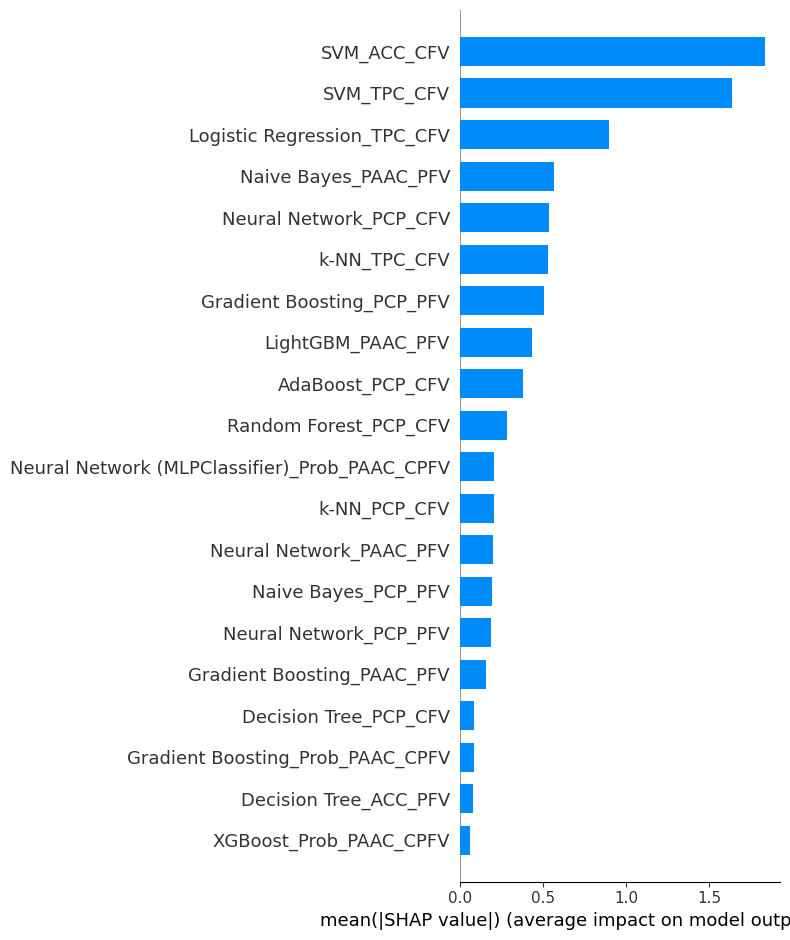

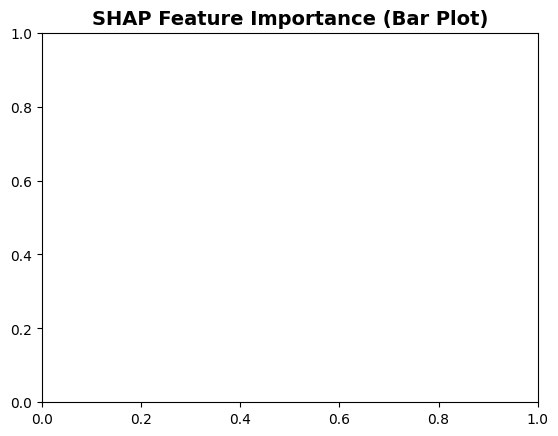

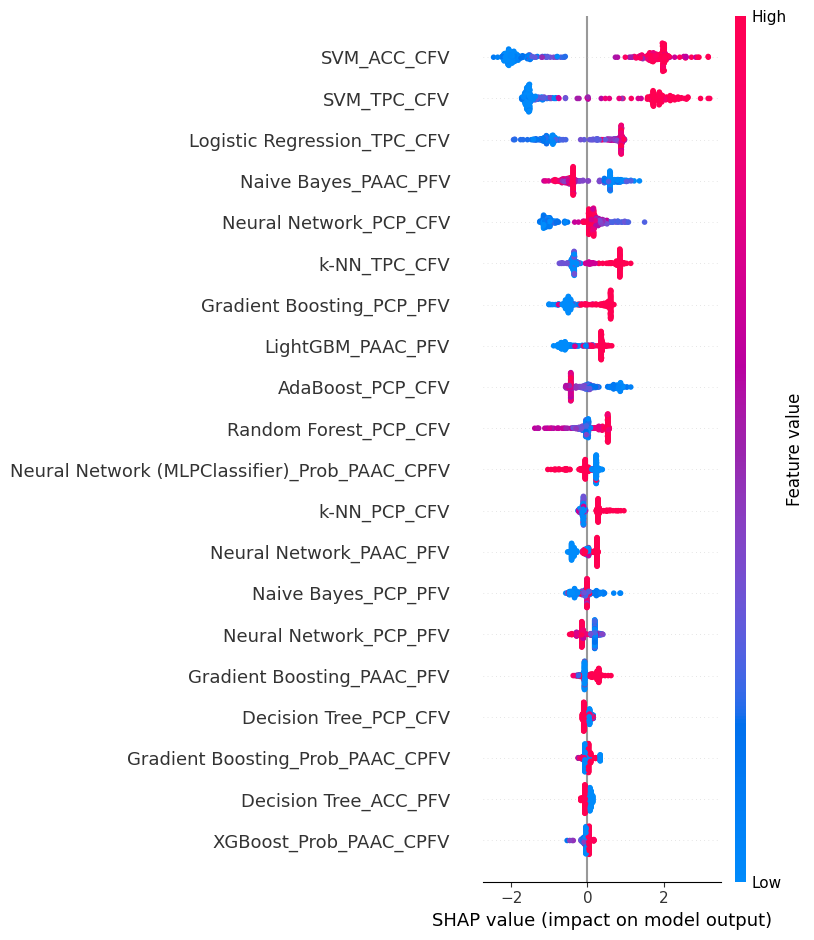

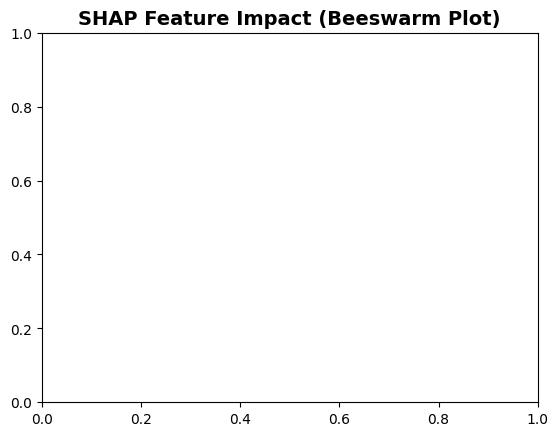

In [ ]:
import pandas as pd
import xgboost
import shap
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/three_T_Marge.csv")

# Assuming the last column is the target variable
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target

# Train an XGBoost model (or any tree-based model)
model = xgboost.XGBClassifier()
model.fit(X, y)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Create the default SHAP summary plot (Bar Plot)
plt.figure(figsize=(6, 4))  # Smaller figure size
shap.summary_plot(shap_values, X, plot_type="bar")  # Bar plot for feature importance
plt.title("SHAP Feature Importance (Bar Plot)", fontsize=14, fontweight='bold')
plt.show()

# Create the default SHAP beeswarm plot
plt.figure(figsize=(3, 3))  # Smaller figure size
shap.summary_plot(shap_values, X)  # Beeswarm plot for detailed feature impact
plt.title("SHAP Feature Impact (Beeswarm Plot)", fontsize=14, fontweight='bold')
plt.show()

Hybrid CNN-LSTM Model for Cell-Penetrating Peptide Classification

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = "/content/three_T_Marge.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional: Uncomment if needed to verify column names)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'Target' column for binary classification
if 'Target' not in data.columns:
    raise ValueError("The dataset must include a 'Target' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['Target']).values  # Features (all columns except 'Target')
y = data['Target'].values                 # Labels (the 'Target' column)

# Split data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]      # Adding channel dimension

# Model Architecture
model = Sequential()

# Stacked Conv1D layers with BatchNormalization and Dropout
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer for sequential dependencies
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Dense Layers for final prediction with Dropout for regularization
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the validation data
val_predictions = (model.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, val_predictions)

print("\nValidation Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_val, val_predictions))




Dataset Columns: Index(['SVM_ACC_CFV', 'AdaBoost_GDC_CFV', 'AdaBoost_CTDT_CFV', 'SVM_DPC_CFV',
       'Random Forest_PAAC_CFV', 'Decision Tree_PAAC_CFV', 'MLP_GDC_CFV',
       'Neural Network_GDC_CFV', 'Random Forest_DPC_CFV', 'XGBoost_CTDT_CFV',
       'Random Forest_Class_GDC_CPFV',
       'Multilayer Perceptron (Custom MLP)_Prob_GDC_CPFV',
       'Neural Network (MLPClassifier)_Class_GDC_CPFV',
       'AdaBoost_Prob_GDC_CPFV', 'AdaBoost_Class_GDC_CPFV',
       'LightGBM_Prob_GDC_CPFV', 'LightGBM_Class_GDC_CPFV',
       'XGBoost_Class_GDC_CPFV', 'Gradient Boosting_Prob_GDC_CPFV',
       'Gradient Boosting_Class_GDC_CPFV', 'SVM_PCP_PFV', 'AdaBoost_PAAC_PFV',
       'MLP_PCP_PFV', 'Neural Network_PCP_PFV', 'LightGBM_PCP_PFV',
       'Gradient Boosting_PCP_PFV', 'Naive Bayes_PCP_PFV', 'k-NN_PCP_PFV',
       'Logistic Regression_PCP_PFV', 'MLP_PAAC_PFV', 'Target'],
      dtype='object')
   SVM_ACC_CFV  AdaBoost_GDC_CFV  AdaBoost_CTDT_CFV  SVM_DPC_CFV  \
0     0.830810          0.609364  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,129 (875.50 KB)

 Trainable params: 223,233 (872.00 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7381 - loss: 0.5804 - val_accuracy: 0.8333 - val_loss: 0.6726
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8770 - loss: 0.3212 - val_accuracy: 0.8111 - val_loss: 0.6693
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8874 - loss: 0.2800 - val_accuracy: 0.7778 - val_loss: 0.6688
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8944 - loss: 0.2796 - val_accuracy: 0.8000 - val_loss: 0.6601
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9014 - loss: 0.2391 - val_accuracy: 0.7778 - val_loss: 0.6537
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9111 - loss: 0.2132 - val_accuracy: 0.7889 - val_loss: 0.6494
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9105 - loss: 0.1793 - val_accuracy: 0.8667 - val_loss: 0.6571
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9037 - loss: 0.2185 - val_accuracy: 0.8778 - val_loss: 

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import optuna

# Load the dataset
dataset_path = "/content/three_T_Marge.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'Target' column for binary classification
if 'Target' not in data.columns:
    raise ValueError("The dataset must include a 'Target' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['Target']).values  # Features
y = data['Target'].values                 # Labels

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]

def objective(trial):
    # Hyperparameter tuning
    num_conv1_filters = trial.suggest_int('num_conv1_filters', 32, 256, step=32)
    kernel_size1 = trial.suggest_int('kernel_size1', 2, 5)
    num_conv2_filters = trial.suggest_int('num_conv2_filters', 64, 256, step=32)
    kernel_size2 = trial.suggest_int('kernel_size2', 2, 5)
    num_lstm_units = trial.suggest_int('num_lstm_units', 32, 128, step=16)
    dense_units1 = trial.suggest_int('dense_units1', 64, 256, step=32)
    dense_units2 = trial.suggest_int('dense_units2', 32, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else RMSprop(learning_rate=learning_rate)

    model = Sequential([
        Conv1D(num_conv1_filters, kernel_size1, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(num_conv2_filters, kernel_size2, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        LSTM(num_lstm_units, activation='relu'),
        Dense(dense_units1, activation='swish'),
        Dropout(dropout_rate),
        Dense(dense_units2, activation='swish'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])

    val_probs = model.predict(X_val).flatten()
    val_predictions = (val_probs > 0.5).astype(int)

    accuracy = accuracy_score(y_val, val_predictions)
    auc_score = roc_auc_score(y_val, val_probs)

    print(f"Trial Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")
    return accuracy  # Return accuracy, or change to auc_score if preferred

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

# Display best hyperparameters
print("\nBest Hyperparameters:", study.best_params)

# Evaluate with best model
best_model = study.best_trial.user_attrs.get("model", None)
if best_model:
    val_probs = best_model.predict(X_val).flatten()
    val_predictions = (val_probs > 0.5).astype(int)
    print("\nFinal Model Accuracy:", accuracy_score(y_val, val_predictions))
    print("\nClassification Report:\n", classification_report(y_val, val_predictions))


[I 2025-02-08 16:16:37,865] A new study created in memory with name: no-name-1d35c2ff-6783-40c4-83c0-b30c9577600c


Dataset Columns: Index(['SVM_ACC_CFV', 'AdaBoost_GDC_CFV', 'AdaBoost_CTDT_CFV', 'SVM_DPC_CFV',
       'Random Forest_PAAC_CFV', 'Decision Tree_PAAC_CFV', 'MLP_GDC_CFV',
       'Neural Network_GDC_CFV', 'Random Forest_DPC_CFV', 'XGBoost_CTDT_CFV',
       'Random Forest_Class_GDC_CPFV',
       'Multilayer Perceptron (Custom MLP)_Prob_GDC_CPFV',
       'Neural Network (MLPClassifier)_Class_GDC_CPFV',
       'AdaBoost_Prob_GDC_CPFV', 'AdaBoost_Class_GDC_CPFV',
       'LightGBM_Prob_GDC_CPFV', 'LightGBM_Class_GDC_CPFV',
       'XGBoost_Class_GDC_CPFV', 'Gradient Boosting_Prob_GDC_CPFV',
       'Gradient Boosting_Class_GDC_CPFV', 'SVM_PCP_PFV', 'AdaBoost_PAAC_PFV',
       'MLP_PCP_PFV', 'Neural Network_PCP_PFV', 'LightGBM_PCP_PFV',
       'Gradient Boosting_PCP_PFV', 'Naive Bayes_PCP_PFV', 'k-NN_PCP_PFV',
       'Logistic Regression_PCP_PFV', 'MLP_PAAC_PFV', 'Target'],
      dtype='object')
   SVM_ACC_CFV  AdaBoost_GDC_CFV  AdaBoost_CTDT_CFV  SVM_DPC_CFV  \
0     0.830810          0.609364  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-02-08 16:17:23,214] Trial 0 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 4, 'num_conv2_filters': 224, 'kernel_size2': 2, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 48, 'dropout_rate': 0.3857564920075546, 'optimizer': 'rmsprop', 'learning_rate': 0.0005195562380018076}. Best is trial 0 with value: 0.8666666666666667.


Trial Accuracy: 0.8667, AUC: 0.9299


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


[I 2025-02-08 16:17:46,952] Trial 1 finished with value: 0.8 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 5, 'num_conv2_filters': 256, 'kernel_size2': 2, 'num_lstm_units': 48, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.3401406880249805, 'optimizer': 'rmsprop', 'learning_rate': 0.0013132844313561518}. Best is trial 0 with value: 0.8666666666666667.


Trial Accuracy: 0.8000, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-08 16:18:22,128] Trial 2 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 4, 'num_conv2_filters': 192, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 256, 'dense_units2': 112, 'dropout_rate': 0.23692517952723882, 'optimizer': 'rmsprop', 'learning_rate': 0.00019770914933264582}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8778, AUC: 0.9017


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step


[I 2025-02-08 16:18:56,695] Trial 3 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 192, 'kernel_size2': 3, 'num_lstm_units': 64, 'dense_units1': 192, 'dense_units2': 80, 'dropout_rate': 0.2154273622014238, 'optimizer': 'adam', 'learning_rate': 0.0008397709584830247}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8778, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-08 16:19:13,032] Trial 4 finished with value: 0.7888888888888889 and parameters: {'num_conv1_filters': 256, 'kernel_size1': 5, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 64, 'dense_units1': 256, 'dense_units2': 112, 'dropout_rate': 0.25041856789309674, 'optimizer': 'rmsprop', 'learning_rate': 0.006070801400068574}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.7889, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-02-08 16:19:38,106] Trial 5 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 64, 'dense_units1': 256, 'dense_units2': 80, 'dropout_rate': 0.46800239572360497, 'optimizer': 'rmsprop', 'learning_rate': 0.00013762792476511678}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8667, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-02-08 16:19:55,609] Trial 6 finished with value: 0.8111111111111111 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 3, 'num_lstm_units': 32, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.49621943217004993, 'optimizer': 'rmsprop', 'learning_rate': 0.006765960260587706}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8111, AUC: 0.9180


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-02-08 16:20:22,239] Trial 7 finished with value: 0.7888888888888889 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 128, 'dense_units1': 256, 'dense_units2': 64, 'dropout_rate': 0.20496349339113573, 'optimizer': 'adam', 'learning_rate': 0.008717252312979968}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.7889, AUC: 0.9195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-02-08 16:20:58,653] Trial 8 finished with value: 0.8333333333333334 and parameters: {'num_conv1_filters': 224, 'kernel_size1': 3, 'num_conv2_filters': 256, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 96, 'dense_units2': 80, 'dropout_rate': 0.2797305877893256, 'optimizer': 'adam', 'learning_rate': 0.0004082772190017886}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8333, AUC: 0.9081


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-02-08 16:21:25,197] Trial 9 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 224, 'kernel_size1': 5, 'num_conv2_filters': 192, 'kernel_size2': 2, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 48, 'dropout_rate': 0.20336051724015175, 'optimizer': 'rmsprop', 'learning_rate': 0.000182556147803304}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8556, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-08 16:21:52,262] Trial 10 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 4, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.3199154616754211, 'optimizer': 'adam', 'learning_rate': 0.0021375838235910944}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8667, AUC: 0.9200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step


[I 2025-02-08 16:22:26,843] Trial 11 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 192, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 192, 'dense_units2': 96, 'dropout_rate': 0.26676720845021396, 'optimizer': 'adam', 'learning_rate': 0.0003882715713381636}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8778, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-02-08 16:22:47,550] Trial 12 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 192, 'kernel_size2': 3, 'num_lstm_units': 80, 'dense_units1': 192, 'dense_units2': 96, 'dropout_rate': 0.4052796737505019, 'optimizer': 'adam', 'learning_rate': 0.002294579046841853}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8667, AUC: 0.9240


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-02-08 16:23:15,621] Trial 13 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 4, 'num_conv2_filters': 160, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.238482931329339, 'optimizer': 'adam', 'learning_rate': 0.00010313698042048924}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8778, AUC: 0.9052


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step


[I 2025-02-08 16:23:40,287] Trial 14 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 224, 'kernel_size2': 3, 'num_lstm_units': 64, 'dense_units1': 160, 'dense_units2': 128, 'dropout_rate': 0.3010934208486797, 'optimizer': 'rmsprop', 'learning_rate': 0.0007837726925312196}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8444, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step


[I 2025-02-08 16:24:15,268] Trial 15 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 4, 'num_conv2_filters': 160, 'kernel_size2': 5, 'num_lstm_units': 80, 'dense_units1': 224, 'dense_units2': 64, 'dropout_rate': 0.23408867959174642, 'optimizer': 'adam', 'learning_rate': 0.0002415794107693615}. Best is trial 2 with value: 0.8777777777777778.


Trial Accuracy: 0.8444, AUC: 0.9131


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-02-08 16:24:38,128] Trial 16 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 224, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.3783100835368919, 'optimizer': 'rmsprop', 'learning_rate': 0.0010446652394180433}. Best is trial 16 with value: 0.8888888888888888.


Trial Accuracy: 0.8889, AUC: 0.9126


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step


[I 2025-02-08 16:24:58,600] Trial 17 finished with value: 0.7888888888888889 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 224, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.3841117023050871, 'optimizer': 'rmsprop', 'learning_rate': 0.0027405593164382554}. Best is trial 16 with value: 0.8888888888888888.


Trial Accuracy: 0.7889, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-02-08 16:25:29,857] Trial 18 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 4, 'num_conv2_filters': 256, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 128, 'dense_units2': 128, 'dropout_rate': 0.43162301454274854, 'optimizer': 'rmsprop', 'learning_rate': 0.0012426474350256298}. Best is trial 16 with value: 0.8888888888888888.


Trial Accuracy: 0.8778, AUC: 0.9151


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-08 16:25:55,762] Trial 19 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 5, 'num_conv2_filters': 224, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 112, 'dropout_rate': 0.3579137859866101, 'optimizer': 'rmsprop', 'learning_rate': 0.00023264988562732324}. Best is trial 16 with value: 0.8888888888888888.


Trial Accuracy: 0.8556, AUC: 0.9022


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-02-08 16:26:20,744] Trial 20 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.4388744375287397, 'optimizer': 'rmsprop', 'learning_rate': 0.0005402550028951545}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2025-02-08 16:26:37,476] Trial 21 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.46676695280587566, 'optimizer': 'rmsprop', 'learning_rate': 0.0005894769233228712}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8222, AUC: 0.9185


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step


[I 2025-02-08 16:27:11,959] Trial 22 finished with value: 0.9 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 224, 'dense_units2': 112, 'dropout_rate': 0.4284345805812696, 'optimizer': 'rmsprop', 'learning_rate': 0.0002720369295788122}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step


[I 2025-02-08 16:27:40,364] Trial 23 finished with value: 0.8 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.43504546975914693, 'optimizer': 'rmsprop', 'learning_rate': 0.00034633423715514015}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8000, AUC: 0.9195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 16:28:13,651] Trial 24 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 160, 'dense_units2': 128, 'dropout_rate': 0.42977811913603037, 'optimizer': 'rmsprop', 'learning_rate': 0.0013419525167168466}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9165


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-02-08 16:28:39,416] Trial 25 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.40041717341634275, 'optimizer': 'rmsprop', 'learning_rate': 0.0006133546509545049}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8222, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step


[I 2025-02-08 16:29:00,655] Trial 26 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 80, 'dropout_rate': 0.363587419108542, 'optimizer': 'rmsprop', 'learning_rate': 0.0035022887645121225}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9091


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-02-08 16:29:36,130] Trial 27 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 160, 'dense_units2': 96, 'dropout_rate': 0.4531253991339573, 'optimizer': 'rmsprop', 'learning_rate': 0.0003332009444498807}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-08 16:29:58,227] Trial 28 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 160, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 192, 'dense_units2': 128, 'dropout_rate': 0.49847269529811955, 'optimizer': 'rmsprop', 'learning_rate': 0.0016826521986080085}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8222, AUC: 0.9170


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-02-08 16:30:24,323] Trial 29 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 112, 'dropout_rate': 0.38218487305289134, 'optimizer': 'rmsprop', 'learning_rate': 0.0005149410413730945}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9328


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 16:30:58,246] Trial 30 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 96, 'dense_units2': 96, 'dropout_rate': 0.4084461654072649, 'optimizer': 'rmsprop', 'learning_rate': 0.0006264746993430751}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9101


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-02-08 16:31:23,079] Trial 31 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 112, 'dropout_rate': 0.37978635396858745, 'optimizer': 'rmsprop', 'learning_rate': 0.0009432125475972705}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9185


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-02-08 16:31:47,478] Trial 32 finished with value: 0.9 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 112, 'dropout_rate': 0.3297200720285363, 'optimizer': 'rmsprop', 'learning_rate': 0.00042167512511940035}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step


[I 2025-02-08 16:32:21,569] Trial 33 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 64, 'dense_units2': 112, 'dropout_rate': 0.3347575579413271, 'optimizer': 'rmsprop', 'learning_rate': 0.00045690623526949625}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9170


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step


[I 2025-02-08 16:32:48,437] Trial 34 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.3335849413377709, 'optimizer': 'rmsprop', 'learning_rate': 0.00023202983959779181}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9151


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 16:33:23,515] Trial 35 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 96, 'dense_units2': 128, 'dropout_rate': 0.30584507278660156, 'optimizer': 'rmsprop', 'learning_rate': 0.0003062103679411845}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9180


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2025-02-08 16:33:48,142] Trial 36 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 112, 'dropout_rate': 0.41316931362391146, 'optimizer': 'rmsprop', 'learning_rate': 0.00048304437216003013}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9343


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-02-08 16:34:14,774] Trial 37 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 80, 'dropout_rate': 0.45041684857460196, 'optimizer': 'rmsprop', 'learning_rate': 0.00015573975262816775}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-02-08 16:34:39,155] Trial 38 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 48, 'dense_units1': 256, 'dense_units2': 96, 'dropout_rate': 0.480113889386291, 'optimizer': 'rmsprop', 'learning_rate': 0.0007473816431593972}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-02-08 16:35:06,332] Trial 39 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 112, 'dropout_rate': 0.3477911553276441, 'optimizer': 'rmsprop', 'learning_rate': 0.00026059847093089336}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 16:35:39,377] Trial 40 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 4, 'num_conv2_filters': 160, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.42219841567660704, 'optimizer': 'rmsprop', 'learning_rate': 0.000506742548560947}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9072


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


[I 2025-02-08 16:36:05,559] Trial 41 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.3271916332290464, 'optimizer': 'rmsprop', 'learning_rate': 0.00019475569869225874}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


[I 2025-02-08 16:36:29,611] Trial 42 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.37126641507253555, 'optimizer': 'rmsprop', 'learning_rate': 0.0002859642519297389}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-02-08 16:37:07,761] Trial 43 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 64, 'dense_units2': 48, 'dropout_rate': 0.39550222017899467, 'optimizer': 'rmsprop', 'learning_rate': 0.0001214599936065478}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9319


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step


[I 2025-02-08 16:37:32,132] Trial 44 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 4, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 80, 'dropout_rate': 0.30832260367473285, 'optimizer': 'rmsprop', 'learning_rate': 0.00040762038817784905}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9062


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step


[I 2025-02-08 16:37:56,377] Trial 45 finished with value: 0.9 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 64, 'dropout_rate': 0.2809156204023053, 'optimizer': 'rmsprop', 'learning_rate': 0.00016568338592572583}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9240


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-02-08 16:38:22,517] Trial 46 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 80, 'dense_units1': 256, 'dense_units2': 96, 'dropout_rate': 0.35089890462774276, 'optimizer': 'adam', 'learning_rate': 0.0002289074620857911}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9086


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2025-02-08 16:38:46,154] Trial 47 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 64, 'dropout_rate': 0.45114031436022384, 'optimizer': 'rmsprop', 'learning_rate': 0.0007070854436000053}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-02-08 16:39:21,633] Trial 48 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 128, 'dense_units2': 32, 'dropout_rate': 0.34119261886615065, 'optimizer': 'rmsprop', 'learning_rate': 0.00037350913703492524}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9160


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step


[I 2025-02-08 16:39:47,209] Trial 49 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.2896496386560212, 'optimizer': 'adam', 'learning_rate': 0.0002147605754639168}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9264


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step


[I 2025-02-08 16:40:14,646] Trial 50 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 2, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 96, 'dropout_rate': 0.31813183558397207, 'optimizer': 'rmsprop', 'learning_rate': 0.00028756899676281533}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 16:40:36,973] Trial 51 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 32, 'dense_units1': 256, 'dense_units2': 96, 'dropout_rate': 0.4729298860608798, 'optimizer': 'rmsprop', 'learning_rate': 0.0008213067754912466}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8444, AUC: 0.9121


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-02-08 16:41:02,367] Trial 52 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 48, 'dense_units1': 256, 'dense_units2': 80, 'dropout_rate': 0.48544972182560264, 'optimizer': 'rmsprop', 'learning_rate': 0.0005294764797224167}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9235


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-02-08 16:41:28,256] Trial 53 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 256, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 80, 'dense_units1': 256, 'dense_units2': 112, 'dropout_rate': 0.39305423536300593, 'optimizer': 'rmsprop', 'learning_rate': 0.0004389031820411707}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9151


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-08 16:41:51,391] Trial 54 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 5, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 48, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.4802204275580691, 'optimizer': 'rmsprop', 'learning_rate': 0.001007348585672578}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9136


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step


[I 2025-02-08 16:42:16,462] Trial 55 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 64, 'dense_units1': 224, 'dense_units2': 112, 'dropout_rate': 0.444015268066653, 'optimizer': 'rmsprop', 'learning_rate': 0.0007206493407136303}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9175


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step


[I 2025-02-08 16:42:45,405] Trial 56 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 3, 'num_lstm_units': 48, 'dense_units1': 256, 'dense_units2': 96, 'dropout_rate': 0.4664978014543547, 'optimizer': 'adam', 'learning_rate': 0.0005660325282766793}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8222, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 16:43:18,513] Trial 57 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 192, 'dense_units2': 80, 'dropout_rate': 0.4146600938289846, 'optimizer': 'rmsprop', 'learning_rate': 0.0012259426437496086}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9175


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2025-02-08 16:43:42,267] Trial 58 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 4, 'num_conv2_filters': 160, 'kernel_size2': 5, 'num_lstm_units': 80, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.3651692647136453, 'optimizer': 'rmsprop', 'learning_rate': 0.00035454250624855735}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-02-08 16:44:14,844] Trial 59 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 64, 'dense_units1': 160, 'dense_units2': 48, 'dropout_rate': 0.259292256008418, 'optimizer': 'rmsprop', 'learning_rate': 0.0006712199456975137}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9072


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step


[I 2025-02-08 16:44:44,022] Trial 60 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 112, 'dropout_rate': 0.4377757576503925, 'optimizer': 'rmsprop', 'learning_rate': 0.0001382463843202584}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


[I 2025-02-08 16:45:08,885] Trial 61 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.37357609955517296, 'optimizer': 'rmsprop', 'learning_rate': 0.00028958041833235037}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9249


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-02-08 16:45:33,297] Trial 62 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 48, 'dropout_rate': 0.36711743983547174, 'optimizer': 'rmsprop', 'learning_rate': 0.0002584484833740593}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-02-08 16:45:59,199] Trial 63 finished with value: 0.9 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 64, 'dense_units2': 32, 'dropout_rate': 0.32602715774674, 'optimizer': 'rmsprop', 'learning_rate': 0.00018726488888635973}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9146


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-02-08 16:46:27,592] Trial 64 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 96, 'dense_units2': 32, 'dropout_rate': 0.3518144588378527, 'optimizer': 'rmsprop', 'learning_rate': 0.00042466745367040684}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-02-08 16:47:04,514] Trial 65 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 96, 'dense_units2': 32, 'dropout_rate': 0.42355677251868656, 'optimizer': 'rmsprop', 'learning_rate': 0.00032753604338603225}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9185


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-02-08 16:47:29,246] Trial 66 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 64, 'dense_units2': 112, 'dropout_rate': 0.33547469096156746, 'optimizer': 'rmsprop', 'learning_rate': 0.0008178805242227795}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9146


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-02-08 16:47:48,210] Trial 67 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 224, 'dense_units2': 48, 'dropout_rate': 0.4605041172124452, 'optimizer': 'adam', 'learning_rate': 0.000528176072549651}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8444, AUC: 0.9170


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


[I 2025-02-08 16:48:52,675] Trial 68 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 192, 'dense_units2': 96, 'dropout_rate': 0.48773254327334614, 'optimizer': 'rmsprop', 'learning_rate': 0.0003759454747664822}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9259


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-02-08 17:03:13,831] Trial 69 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 64, 'dropout_rate': 0.39220612589452636, 'optimizer': 'rmsprop', 'learning_rate': 0.004488533369201741}. Best is trial 20 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9170

Best Hyperparameters: {'num_conv1_filters': 128, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.4388744375287397, 'optimizer': 'rmsprop', 'learning_rate': 0.0005402550028951545}


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef, cohen_kappa_score
from sklearn.model_selection import train_test_split
import optuna

# Load the dataset
dataset_path = "/content/three_T_Marge.csv"
data = pd.read_csv(dataset_path)

# Inspect the dataset (Optional)
print("Dataset Columns:", data.columns)
print(data.head())

# Ensure the dataset contains a 'Target' column for binary classification
if 'Target' not in data.columns:
    raise ValueError("The dataset must include a 'Target' column for binary classification.")

# Separate features and labels
X = data.drop(columns=['Target']).values  # Features
y = data['Target'].values                 # Labels

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data for Conv1D input
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_val = X_val[..., np.newaxis]

def objective(trial):
    # Hyperparameter tuning
    num_conv1_filters = trial.suggest_int('num_conv1_filters', 32, 256, step=32)
    kernel_size1 = trial.suggest_int('kernel_size1', 2, 5)
    num_conv2_filters = trial.suggest_int('num_conv2_filters', 64, 256, step=32)
    kernel_size2 = trial.suggest_int('kernel_size2', 2, 5)
    num_lstm_units = trial.suggest_int('num_lstm_units', 32, 128, step=16)
    dense_units1 = trial.suggest_int('dense_units1', 64, 256, step=32)
    dense_units2 = trial.suggest_int('dense_units2', 32, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else RMSprop(learning_rate=learning_rate)

    model = Sequential([
        Conv1D(num_conv1_filters, kernel_size1, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(num_conv2_filters, kernel_size2, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        LSTM(num_lstm_units, activation='relu'),
        Dense(dense_units1, activation='swish'),
        Dropout(dropout_rate),
        Dense(dense_units2, activation='swish'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=59, batch_size=32, verbose=0, callbacks=[early_stopping])

    val_probs = model.predict(X_val).flatten()
    val_predictions = (val_probs > 0.5).astype(int)

    accuracy = accuracy_score(y_val, val_predictions)
    auc_score = roc_auc_score(y_val, val_probs)

    print(f"Trial Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")
    return accuracy  # Return accuracy, or change to auc_score if preferred

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

# Display best hyperparameters
print("\nBest Hyperparameters:", study.best_params)

# Evaluate with best model
best_model = study.best_trial.user_attrs.get("model", None)
if best_model:
    val_probs = best_model.predict(X_val).flatten()
    val_predictions = (val_probs > 0.5).astype(int)

    # Compute additional metrics
    tn, fp, fn, tp = confusion_matrix(y_val, val_predictions).ravel()

    sensitivity = tp / (tp + fn)  # Recall or True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    mcc = matthews_corrcoef(y_val, val_predictions)  # Matthews Correlation Coefficient
    kappa = cohen_kappa_score(y_val, val_predictions)  # Cohen’s Kappa
    auc = roc_auc_score(y_val, val_probs)  # AUC-ROC Score

    # Print final evaluation metrics
    print("\nFinal Model Accuracy:", accuracy_score(y_val, val_predictions))
    print("\nClassification Report:\n", classification_report(y_val, val_predictions))

    # Print additional metrics
    print(f"Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print(f"AUC: {auc:.4f}")


[I 2025-02-08 17:12:52,705] A new study created in memory with name: no-name-16d55b56-5395-4169-aba5-191929ca22b1


Dataset Columns: Index(['SVM_ACC_CFV', 'AdaBoost_GDC_CFV', 'AdaBoost_CTDT_CFV', 'SVM_DPC_CFV',
       'Random Forest_PAAC_CFV', 'Decision Tree_PAAC_CFV', 'MLP_GDC_CFV',
       'Neural Network_GDC_CFV', 'Random Forest_DPC_CFV', 'XGBoost_CTDT_CFV',
       'Random Forest_Class_GDC_CPFV',
       'Multilayer Perceptron (Custom MLP)_Prob_GDC_CPFV',
       'Neural Network (MLPClassifier)_Class_GDC_CPFV',
       'AdaBoost_Prob_GDC_CPFV', 'AdaBoost_Class_GDC_CPFV',
       'LightGBM_Prob_GDC_CPFV', 'LightGBM_Class_GDC_CPFV',
       'XGBoost_Class_GDC_CPFV', 'Gradient Boosting_Prob_GDC_CPFV',
       'Gradient Boosting_Class_GDC_CPFV', 'SVM_PCP_PFV', 'AdaBoost_PAAC_PFV',
       'MLP_PCP_PFV', 'Neural Network_PCP_PFV', 'LightGBM_PCP_PFV',
       'Gradient Boosting_PCP_PFV', 'Naive Bayes_PCP_PFV', 'k-NN_PCP_PFV',
       'Logistic Regression_PCP_PFV', 'MLP_PAAC_PFV', 'Target'],
      dtype='object')
   SVM_ACC_CFV  AdaBoost_GDC_CFV  AdaBoost_CTDT_CFV  SVM_DPC_CFV  \
0     0.830810          0.609364  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-08 17:13:27,061] Trial 0 finished with value: 0.9 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 80, 'dense_units1': 192, 'dense_units2': 128, 'dropout_rate': 0.4839862331249046, 'optimizer': 'rmsprop', 'learning_rate': 0.001106774442634639}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.9000, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-02-08 17:14:03,430] Trial 1 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 224, 'kernel_size1': 3, 'num_conv2_filters': 192, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 64, 'dense_units2': 96, 'dropout_rate': 0.2596642225355303, 'optimizer': 'rmsprop', 'learning_rate': 0.0002605735135089195}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9175


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step


[I 2025-02-08 17:14:35,138] Trial 2 finished with value: 0.8111111111111111 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 4, 'num_conv2_filters': 224, 'kernel_size2': 3, 'num_lstm_units': 80, 'dense_units1': 96, 'dense_units2': 32, 'dropout_rate': 0.25848224107020806, 'optimizer': 'adam', 'learning_rate': 0.0021634584182793994}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8111, AUC: 0.8993


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-02-08 17:15:11,196] Trial 3 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 112, 'dense_units1': 256, 'dense_units2': 80, 'dropout_rate': 0.2730947665006397, 'optimizer': 'adam', 'learning_rate': 0.0003321573245169928}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9304


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 17:15:39,214] Trial 4 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 256, 'kernel_size1': 5, 'num_conv2_filters': 128, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.49016849942708585, 'optimizer': 'rmsprop', 'learning_rate': 0.000123982789004588}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 17:16:06,512] Trial 5 finished with value: 0.7777777777777778 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 32, 'dense_units1': 256, 'dense_units2': 32, 'dropout_rate': 0.35412968939420564, 'optimizer': 'adam', 'learning_rate': 0.0008971659482459025}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.7778, AUC: 0.9116


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-02-08 17:16:41,744] Trial 6 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 4, 'num_conv2_filters': 256, 'kernel_size2': 3, 'num_lstm_units': 64, 'dense_units1': 128, 'dense_units2': 128, 'dropout_rate': 0.49036136476788067, 'optimizer': 'adam', 'learning_rate': 0.0007602537873880895}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9190


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 17:17:08,998] Trial 7 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 4, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 64, 'dense_units1': 224, 'dense_units2': 64, 'dropout_rate': 0.310008476581179, 'optimizer': 'adam', 'learning_rate': 0.009682706094832141}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8444, AUC: 0.9304


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


[I 2025-02-08 17:17:43,220] Trial 8 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 5, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 128, 'dense_units1': 256, 'dense_units2': 64, 'dropout_rate': 0.2830558687800415, 'optimizer': 'adam', 'learning_rate': 0.0005106651378706238}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9358


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-02-08 17:18:02,425] Trial 9 finished with value: 0.8 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 80, 'dense_units1': 160, 'dense_units2': 32, 'dropout_rate': 0.21599163809649313, 'optimizer': 'adam', 'learning_rate': 0.0004697282487490249}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8000, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-08 17:18:31,809] Trial 10 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.4115072619104671, 'optimizer': 'rmsprop', 'learning_rate': 0.0027121556631505826}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8889, AUC: 0.9244


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


[I 2025-02-08 17:19:03,322] Trial 11 finished with value: 0.8333333333333334 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 112, 'dense_units1': 192, 'dense_units2': 80, 'dropout_rate': 0.39693855584469634, 'optimizer': 'rmsprop', 'learning_rate': 0.0019674978048630186}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8333, AUC: 0.9195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-02-08 17:19:32,656] Trial 12 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 192, 'dense_units2': 96, 'dropout_rate': 0.4334677745759173, 'optimizer': 'rmsprop', 'learning_rate': 0.00019816400550614393}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8667, AUC: 0.9116


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-02-08 17:20:07,119] Trial 13 finished with value: 0.8111111111111111 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 160, 'kernel_size2': 2, 'num_lstm_units': 96, 'dense_units1': 224, 'dense_units2': 64, 'dropout_rate': 0.3397802502981735, 'optimizer': 'rmsprop', 'learning_rate': 0.00029916678191416163}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8111, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-02-08 17:20:28,061] Trial 14 finished with value: 0.8111111111111111 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 3, 'num_lstm_units': 112, 'dense_units1': 160, 'dense_units2': 96, 'dropout_rate': 0.2241451062350765, 'optimizer': 'adam', 'learning_rate': 0.0043226919472404545}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8111, AUC: 0.9294


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


[I 2025-02-08 17:21:00,630] Trial 15 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 160, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 224, 'dense_units2': 80, 'dropout_rate': 0.45183994516042, 'optimizer': 'rmsprop', 'learning_rate': 0.001349271069142512}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9165


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-02-08 17:21:37,224] Trial 16 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 48, 'dense_units1': 128, 'dense_units2': 112, 'dropout_rate': 0.3487034565041388, 'optimizer': 'rmsprop', 'learning_rate': 0.00048885059777424}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-02-08 17:22:16,786] Trial 17 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 48, 'dropout_rate': 0.3820508193515871, 'optimizer': 'adam', 'learning_rate': 0.00010713433792450806}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8556, AUC: 0.9259


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-02-08 17:22:47,668] Trial 18 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 160, 'kernel_size2': 4, 'num_lstm_units': 80, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.31482269683195285, 'optimizer': 'adam', 'learning_rate': 0.0012735915915261062}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step


[I 2025-02-08 17:23:07,979] Trial 19 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 128, 'dense_units2': 80, 'dropout_rate': 0.4576781637241417, 'optimizer': 'rmsprop', 'learning_rate': 0.0052473916041157085}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8222, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step


[I 2025-02-08 17:23:36,058] Trial 20 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 256, 'kernel_size1': 2, 'num_conv2_filters': 128, 'kernel_size2': 2, 'num_lstm_units': 48, 'dense_units1': 256, 'dense_units2': 48, 'dropout_rate': 0.20119979743340546, 'optimizer': 'rmsprop', 'learning_rate': 0.00018431965683509652}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-08 17:23:56,718] Trial 21 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.41797234416050444, 'optimizer': 'rmsprop', 'learning_rate': 0.0024234443730546803}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9170


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 17:24:26,877] Trial 22 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 48, 'dense_units1': 160, 'dense_units2': 128, 'dropout_rate': 0.3839223963720265, 'optimizer': 'rmsprop', 'learning_rate': 0.0032426031639375213}. Best is trial 0 with value: 0.9.


Trial Accuracy: 0.8778, AUC: 0.9215


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-02-08 17:24:49,977] Trial 23 finished with value: 0.9111111111111111 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.4572886914281392, 'optimizer': 'rmsprop', 'learning_rate': 0.0014230000820774995}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9111, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 17:25:25,159] Trial 24 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 3, 'num_lstm_units': 128, 'dense_units1': 160, 'dense_units2': 96, 'dropout_rate': 0.49837370271681614, 'optimizer': 'rmsprop', 'learning_rate': 0.0006912974532310119}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-02-08 17:25:47,204] Trial 25 finished with value: 0.9 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 96, 'dense_units2': 128, 'dropout_rate': 0.4654661339818517, 'optimizer': 'rmsprop', 'learning_rate': 0.0014628671409510183}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9000, AUC: 0.9210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-02-08 17:26:10,253] Trial 26 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 4, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 64, 'dense_units2': 128, 'dropout_rate': 0.46360919410434126, 'optimizer': 'rmsprop', 'learning_rate': 0.001470957224911602}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9254


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


[I 2025-02-08 17:26:33,326] Trial 27 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 192, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 96, 'dense_units2': 128, 'dropout_rate': 0.47177974191499555, 'optimizer': 'rmsprop', 'learning_rate': 0.0011592386671668117}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9244


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-02-08 17:27:07,689] Trial 28 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 112, 'dropout_rate': 0.4328970827614493, 'optimizer': 'rmsprop', 'learning_rate': 0.0017239675173682959}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8556, AUC: 0.9264


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-02-08 17:27:31,506] Trial 29 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 128, 'dense_units1': 128, 'dense_units2': 128, 'dropout_rate': 0.44042893168907216, 'optimizer': 'rmsprop', 'learning_rate': 0.0009152509350074101}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9057


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-02-08 17:27:50,537] Trial 30 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 192, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 64, 'dense_units2': 96, 'dropout_rate': 0.4744446575454246, 'optimizer': 'rmsprop', 'learning_rate': 0.003852922877804752}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9269


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-02-08 17:28:15,394] Trial 31 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 96, 'dense_units2': 112, 'dropout_rate': 0.25561278181811764, 'optimizer': 'rmsprop', 'learning_rate': 0.00037030995720612305}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


[I 2025-02-08 17:28:35,108] Trial 32 finished with value: 0.7777777777777778 and parameters: {'num_conv1_filters': 224, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 80, 'dense_units1': 64, 'dense_units2': 128, 'dropout_rate': 0.2815028232564717, 'optimizer': 'adam', 'learning_rate': 0.0006876239040888729}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.7778, AUC: 0.9195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-02-08 17:29:10,054] Trial 33 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 96, 'dropout_rate': 0.4787894547144196, 'optimizer': 'rmsprop', 'learning_rate': 0.0009728770913251985}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9240


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 17:29:32,911] Trial 34 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 5, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 128, 'dense_units1': 160, 'dense_units2': 80, 'dropout_rate': 0.4484777092272851, 'optimizer': 'adam', 'learning_rate': 0.0015760280332571975}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9328


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step


[I 2025-02-08 17:29:58,537] Trial 35 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 224, 'kernel_size1': 4, 'num_conv2_filters': 224, 'kernel_size2': 5, 'num_lstm_units': 112, 'dense_units1': 256, 'dense_units2': 112, 'dropout_rate': 0.48530619236816375, 'optimizer': 'rmsprop', 'learning_rate': 0.0006203240652186169}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.8988


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-02-08 17:30:18,478] Trial 36 finished with value: 0.7777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 128, 'dense_units2': 128, 'dropout_rate': 0.4150087402943754, 'optimizer': 'adam', 'learning_rate': 0.0064869359206560905}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.7778, AUC: 0.9077


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step


[I 2025-02-08 17:30:38,753] Trial 37 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 4, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 80, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.3669643382945723, 'optimizer': 'adam', 'learning_rate': 0.002108949107422473}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8556, AUC: 0.9200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-02-08 17:31:11,909] Trial 38 finished with value: 0.8 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 96, 'dense_units1': 96, 'dense_units2': 80, 'dropout_rate': 0.325441859238898, 'optimizer': 'rmsprop', 'learning_rate': 0.001124373856941203}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8000, AUC: 0.8948


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step


[I 2025-02-08 17:31:47,376] Trial 39 finished with value: 0.9111111111111111 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 256, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 192, 'dense_units2': 64, 'dropout_rate': 0.4991207826449434, 'optimizer': 'adam', 'learning_rate': 0.0003394783599300136}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9111, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 17:32:23,729] Trial 40 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 256, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 192, 'dense_units2': 48, 'dropout_rate': 0.49824109794194615, 'optimizer': 'adam', 'learning_rate': 0.00020972578575635046}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 17:32:48,355] Trial 41 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 224, 'kernel_size2': 4, 'num_lstm_units': 80, 'dense_units1': 224, 'dense_units2': 64, 'dropout_rate': 0.46667457210615954, 'optimizer': 'adam', 'learning_rate': 0.0003390636066781761}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2025-02-08 17:33:25,255] Trial 42 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 256, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 160, 'dense_units2': 64, 'dropout_rate': 0.4839736448207552, 'optimizer': 'adam', 'learning_rate': 0.0002439166006244325}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9215


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step


[I 2025-02-08 17:34:01,319] Trial 43 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 224, 'kernel_size2': 4, 'num_lstm_units': 80, 'dense_units1': 192, 'dense_units2': 64, 'dropout_rate': 0.2834240627096231, 'optimizer': 'adam', 'learning_rate': 0.00014594538894512697}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9215


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step


[I 2025-02-08 17:34:30,491] Trial 44 finished with value: 0.8333333333333334 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 2, 'num_lstm_units': 128, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.24982309105122147, 'optimizer': 'adam', 'learning_rate': 0.00038735591459082666}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8333, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-02-08 17:34:48,058] Trial 45 finished with value: 0.7888888888888889 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 5, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 64, 'dense_units1': 192, 'dense_units2': 80, 'dropout_rate': 0.4288470270819292, 'optimizer': 'adam', 'learning_rate': 0.0005677066809739889}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.7889, AUC: 0.9195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step


[I 2025-02-08 17:35:11,798] Trial 46 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 192, 'kernel_size2': 3, 'num_lstm_units': 48, 'dense_units1': 128, 'dense_units2': 96, 'dropout_rate': 0.4490559631625852, 'optimizer': 'rmsprop', 'learning_rate': 0.0007824693720927362}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8556, AUC: 0.9259


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 17:35:45,008] Trial 47 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 4, 'num_conv2_filters': 128, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.4987786591176432, 'optimizer': 'adam', 'learning_rate': 0.0008148861553032437}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9249


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-02-08 17:36:10,369] Trial 48 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 224, 'dense_units2': 48, 'dropout_rate': 0.404472161214409, 'optimizer': 'rmsprop', 'learning_rate': 0.0004488131770144706}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9299


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-08 17:36:27,873] Trial 49 finished with value: 0.8222222222222222 and parameters: {'num_conv1_filters': 192, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 64, 'dropout_rate': 0.29266012998697044, 'optimizer': 'adam', 'learning_rate': 0.0027784656928479057}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8222, AUC: 0.9200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-02-08 17:36:54,484] Trial 50 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 128, 'kernel_size1': 3, 'num_conv2_filters': 128, 'kernel_size2': 5, 'num_lstm_units': 80, 'dense_units1': 192, 'dense_units2': 80, 'dropout_rate': 0.4651024083405445, 'optimizer': 'rmsprop', 'learning_rate': 0.0002649028812196163}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8778, AUC: 0.9249


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-02-08 17:37:16,833] Trial 51 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.48107988621256026, 'optimizer': 'rmsprop', 'learning_rate': 0.0018295033635580284}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9269


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-02-08 17:37:32,856] Trial 52 finished with value: 0.7222222222222222 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 32, 'dense_units1': 192, 'dense_units2': 96, 'dropout_rate': 0.4420510566381721, 'optimizer': 'rmsprop', 'learning_rate': 0.002488511367442217}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.7222, AUC: 0.9220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-02-08 17:37:51,503] Trial 53 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 48, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.41445551176483375, 'optimizer': 'rmsprop', 'learning_rate': 0.0029981721592808952}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8778, AUC: 0.9200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-02-08 17:38:13,315] Trial 54 finished with value: 0.9 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.37856734784545365, 'optimizer': 'rmsprop', 'learning_rate': 0.0013663088363370757}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9000, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-02-08 17:38:34,423] Trial 55 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 2, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.23847311527129977, 'optimizer': 'rmsprop', 'learning_rate': 0.0010421851950394275}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8444, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-02-08 17:38:57,230] Trial 56 finished with value: 0.8555555555555555 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.36465464754741805, 'optimizer': 'rmsprop', 'learning_rate': 0.0012979717717398252}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8556, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


[I 2025-02-08 17:39:19,442] Trial 57 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 160, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 2, 'num_lstm_units': 128, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.3351521977725253, 'optimizer': 'rmsprop', 'learning_rate': 0.0016748375027141151}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9170


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-02-08 17:39:41,841] Trial 58 finished with value: 0.8777777777777778 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 2, 'num_conv2_filters': 160, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 48, 'dropout_rate': 0.3962431527019364, 'optimizer': 'adam', 'learning_rate': 0.0013994257689124115}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8778, AUC: 0.9225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-02-08 17:40:04,543] Trial 59 finished with value: 0.9111111111111111 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.45773325639056367, 'optimizer': 'rmsprop', 'learning_rate': 0.002025057377990718}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9111, AUC: 0.9205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-02-08 17:40:36,857] Trial 60 finished with value: 0.9 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.4242733915510756, 'optimizer': 'rmsprop', 'learning_rate': 0.0020795616532204336}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.9000, AUC: 0.9244


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-02-08 17:40:57,842] Trial 61 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.45561768911810746, 'optimizer': 'rmsprop', 'learning_rate': 0.0020289580210517237}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8444, AUC: 0.9299


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-02-08 17:41:18,538] Trial 62 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.4260524312884954, 'optimizer': 'rmsprop', 'learning_rate': 0.00230794647646852}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9235


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-02-08 17:41:39,897] Trial 63 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 80, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.46034301426501095, 'optimizer': 'rmsprop', 'learning_rate': 0.003641345605668129}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9175


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-02-08 17:41:55,836] Trial 64 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.4883942316805539, 'optimizer': 'rmsprop', 'learning_rate': 0.0011255215161211473}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9151


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 17:42:25,631] Trial 65 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 3, 'num_lstm_units': 112, 'dense_units1': 224, 'dense_units2': 112, 'dropout_rate': 0.4711093624665582, 'optimizer': 'rmsprop', 'learning_rate': 0.0018549914528310258}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9323


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-02-08 17:42:48,551] Trial 66 finished with value: 0.8666666666666667 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 2, 'num_conv2_filters': 96, 'kernel_size2': 3, 'num_lstm_units': 64, 'dense_units1': 224, 'dense_units2': 128, 'dropout_rate': 0.4381939851570643, 'optimizer': 'rmsprop', 'learning_rate': 0.0014079129653573495}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8667, AUC: 0.9269


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-02-08 17:43:04,766] Trial 67 finished with value: 0.8333333333333334 and parameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 96, 'dense_units1': 256, 'dense_units2': 32, 'dropout_rate': 0.3869852555793159, 'optimizer': 'rmsprop', 'learning_rate': 0.0009341637877405674}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8333, AUC: 0.9190


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-02-08 17:43:25,472] Trial 68 finished with value: 0.8888888888888888 and parameters: {'num_conv1_filters': 32, 'kernel_size1': 4, 'num_conv2_filters': 96, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 192, 'dense_units2': 112, 'dropout_rate': 0.42526275553507953, 'optimizer': 'rmsprop', 'learning_rate': 0.0015514584260716536}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8889, AUC: 0.9230


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


[I 2025-02-08 17:45:07,568] Trial 69 finished with value: 0.8444444444444444 and parameters: {'num_conv1_filters': 96, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 112, 'dense_units1': 128, 'dense_units2': 128, 'dropout_rate': 0.44690090962670637, 'optimizer': 'rmsprop', 'learning_rate': 0.00119045351608449}. Best is trial 23 with value: 0.9111111111111111.


Trial Accuracy: 0.8444, AUC: 0.9269

Best Hyperparameters: {'num_conv1_filters': 64, 'kernel_size1': 3, 'num_conv2_filters': 64, 'kernel_size2': 4, 'num_lstm_units': 128, 'dense_units1': 160, 'dense_units2': 112, 'dropout_rate': 0.4572886914281392, 'optimizer': 'rmsprop', 'learning_rate': 0.0014230000820774995}
